In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#!pip install pandas
#!pip install tqdm
#!pip install scipy
#!pip install matchms
#!pip install scikit-learn
#!pip install spec2vec
#!pip install seaborn

In [4]:
import pickle

In [5]:
import os
os.chdir('/Users/sebas/projects/metabolomics')

In [6]:
from tqdm import tqdm
import gensim
import matchms.filtering as msfilters
import dill
from spec2vec import Spec2Vec
from tqdm import tqdm
from matchms import calculate_scores
from matchms.similarity import FingerprintSimilarity
from matchms.filtering import add_fingerprint
from matchms import calculate_scores
import matplotlib.pyplot  as plt
from sklearn.metrics import roc_curve, auc
from ms2deepscore.models import load_model
from ms2deepscore import MS2DeepScore
import numpy as np

## Parameters

In [7]:
model_spec2vec_file = '/Users/sebas/projects/data/spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model'
model_ms2d_file= '/Users/sebas/projects/data/ms2deepscore_positive_10k_1000_1000_1000_500.hdf5'
threshold_analogs=0.7

## load spectrums

In [8]:
with open('./spectrums_sent.pkl', 'rb') as f:
    spectrums = dill.load(f)

In [9]:
spectrums

[Spectrum(precursor m/z=569.00, 123 fragments between 164.3 and 550.7),
 Spectrum(precursor m/z=591.00, 267 fragments between 169.5 and 690.2),
 Spectrum(precursor m/z=567.00, 85 fragments between 164.4 and 568.5),
 Spectrum(precursor m/z=687.10, 17 fragments between 276.9 and 687.3),
 Spectrum(precursor m/z=850.64, 64 fragments between 183.1 and 854.7),
 Spectrum(precursor m/z=737.40, 62 fragments between 233.0 and 736.3),
 Spectrum(precursor m/z=739.21, 117 fragments between 207.6 and 739.1),
 Spectrum(precursor m/z=696.30, 257 fragments between 103.1 and 667.9),
 Spectrum(precursor m/z=789.00, 82 fragments between 229.0 and 789.4),
 Spectrum(precursor m/z=565.76, 36 fragments between 171.1 and 486.2),
 Spectrum(precursor m/z=838.30, 31 fragments between 386.8 and 820.8),
 Spectrum(precursor m/z=567.00, 14 fragments between 158.8 and 534.9),
 Spectrum(precursor m/z=367.00, 7 fragments between 217.3 and 284.0),
 Spectrum(precursor m/z=450.80, 40 fragments between 134.4 and 451.5),
 Sp

In [10]:
spectrums[0].metadata

{'charge': 0,
 'ionmode': 'positive',
 'smiles': 'C[C@H]1C=CC(=O)N1C(=O)/C=C(\\CCNC(=O)CC/C=C/C(C)CC/C(=C/Cl)/CCCC#CBr)/OC',
 'inchi': 'InChI=1S/C27H36BrClN2O4/c1-21(12-14-23(20-29)10-5-4-8-17-28)9-6-7-11-25(32)30-18-16-24(35-3)19-27(34)31-22(2)13-15-26(31)33/h6,9,13,15,19-22H,4-5,7,10-12,14,16,18H2,1-3H3,(H,30,32)/b9-6+,23-20+,24-19+/t21?,22-/m0/s1',
 'scans': '1',
 'ms_level': '2',
 'instrument_type': 'LC-ESI-qTof',
 'file_name': '20120412_PAVL_FT_JamaicamideA_MCl37H_569_qb.1.1..mgf',
 'peptide_sequence': '*..*',
 'organism_name': 'GNPS-LIBRARY',
 'compound_name': 'Jamaicamide A M+H',
 'principal_investigator': 'Gerwick',
 'data_collector': 'PAVL',
 'submit_user': 'mwang87',
 'confidence': '1',
 'spectrum_id': 'CCMSLIB00000001560',
 'precursor_mz': 569.0,
 'fingerprint': array([0, 0, 1, ..., 0, 0, 1])}

In [11]:
len(spectrums)

31990

## load pairs (indexes)

In [12]:
with open('./pairs_indexes.pkl', 'rb') as f:
    pairs = pickle.load(f)

In [13]:
pairs

[(6300, 3019),
 (5625, 2791),
 (2205, 2561),
 (2705, 5274),
 (292, 4865),
 (3907, 4107),
 (403, 5241),
 (6305, 3814),
 (4419, 5842),
 (5819, 364),
 (4436, 3640),
 (428, 5639),
 (6377, 6099),
 (1327, 778),
 (3864, 2339),
 (6313, 5490),
 (3985, 3759),
 (6057, 1353),
 (3155, 1709),
 (4458, 3121),
 (467, 5342),
 (929, 1897),
 (2877, 4567),
 (5779, 3280),
 (2608, 1969),
 (2337, 1398),
 (673, 2608),
 (6124, 4417),
 (1731, 1213),
 (4418, 963),
 (604, 4608),
 (3803, 1336),
 (1695, 4110),
 (2271, 1194),
 (4048, 4443),
 (3862, 518),
 (880, 1242),
 (4245, 3779),
 (3985, 6014),
 (356, 5445),
 (6304, 5575),
 (4340, 2604),
 (3879, 4796),
 (880, 1220),
 (1476, 5379),
 (208, 1446),
 (3180, 3565),
 (6152, 4381),
 (2587, 130),
 (1777, 2791),
 (3223, 3211),
 (2159, 2628),
 (5849, 1507),
 (4844, 1242),
 (1431, 4119),
 (6160, 6374),
 (1173, 5779),
 (2428, 1213),
 (3777, 2475),
 (5672, 1427),
 (2766, 3687),
 (6159, 6108),
 (1281, 6088),
 (4241, 2475),
 (4086, 2790),
 (6123, 4546),
 (4080, 4632),
 (3971, 344

## Preprocess data for spec2vec

In [14]:
def spectrum_processing(s):
        """This is how one would typically design a desired pre- and post-
        processing pipeline."""
        s = msfilters.default_filters(s)
        s = msfilters.add_parent_mass(s)
        s = msfilters.normalize_intensities(s)
        s = msfilters.reduce_to_number_of_peaks(s, n_required=10, ratio_desired=None, n_max=500)
        #s = msfilters.reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5, n_max=500)
        s = msfilters.select_by_mz(s, mz_from=0, mz_to=1000)
        s = msfilters.add_losses(s, loss_mz_from=10.0, loss_mz_to=200.0)
        s = msfilters.require_minimum_number_of_peaks(s, n_required=10)
        return s

In [ ]:
# preprocess for spec2vec
spectrums_spec2vec=spectrums.copy()
for i in tqdm(range(len(spectrums))):
    spectrums_spec2vec[i] = spectrum_processing(spectrums[i])

 20%|██████████████████████████████████▌                                                                                                                                      | 6552/31990 [00:11<00:41, 610.36it/s]

2024-02-09 13:50:31,706:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:31,706:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:31,707:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:31,708:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:31,709:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:31,709:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:31,711:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 21%|██████████████████████████████████▉                                                                                                                                      | 6617/31990 [00:11<00:40, 620.12it/s]

2024-02-09 13:50:31,738:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:31,738:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:31,739:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:31,739:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:31,740:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:31,741:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:31,742:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 21%|███████████████████████████████████▎                                                                                                                                     | 6691/31990 [00:11<00:38, 655.55it/s]

2024-02-09 13:50:31,838:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:31,838:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:31,839:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:31,840:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:31,841:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:31,841:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:31,842:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 21%|███████████████████████████████████▋                                                                                                                                     | 6763/31990 [00:11<00:37, 671.84it/s]

2024-02-09 13:50:31,939:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:31,940:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:31,941:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:31,941:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:31,943:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:31,943:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:31,944:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 21%|████████████████████████████████████                                                                                                                                     | 6835/31990 [00:11<00:38, 661.77it/s]

2024-02-09 13:50:32,052:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,052:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,053:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,053:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,055:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,055:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,056:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 22%|████████████████████████████████████▍                                                                                                                                    | 6904/31990 [00:11<00:37, 669.23it/s]

2024-02-09 13:50:32,152:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,152:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,154:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,154:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,155:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,155:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,157:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 22%|████████████████████████████████████▊                                                                                                                                    | 6972/31990 [00:11<00:37, 671.42it/s]

2024-02-09 13:50:32,253:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,253:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,254:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,254:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,256:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,256:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,257:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 22%|█████████████████████████████████████▏                                                                                                                                   | 7040/31990 [00:11<00:40, 616.07it/s]

2024-02-09 13:50:32,385:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,385:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,386:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,386:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,387:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,387:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,388:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 22%|█████████████████████████████████████▌                                                                                                                                   | 7113/31990 [00:11<00:38, 647.07it/s]

2024-02-09 13:50:32,485:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,485:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,487:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,487:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,488:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,488:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,489:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 22%|█████████████████████████████████████▉                                                                                                                                   | 7179/31990 [00:12<00:40, 607.99it/s]

2024-02-09 13:50:32,610:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,610:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,611:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,611:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,612:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,612:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,613:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 23%|██████████████████████████████████████▎                                                                                                                                  | 7257/31990 [00:12<00:37, 654.00it/s]

2024-02-09 13:50:32,711:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,711:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,712:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,712:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,713:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,714:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,715:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 23%|██████████████████████████████████████▋                                                                                                                                  | 7324/31990 [00:12<00:39, 622.43it/s]

2024-02-09 13:50:32,831:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,831:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,832:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,833:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,834:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,834:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,836:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 23%|███████████████████████████████████████                                                                                                                                  | 7388/31990 [00:12<00:41, 588.90it/s]

2024-02-09 13:50:32,955:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,955:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,956:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,956:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,958:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:32,958:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:32,959:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 23%|███████████████████████████████████████▍                                                                                                                                 | 7463/31990 [00:12<00:38, 631.46it/s]

2024-02-09 13:50:33,055:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:33,055:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:33,056:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:33,057:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:33,057:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:33,058:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:33,059:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 24%|███████████████████████████████████████▊                                                                                                                                 | 7528/31990 [00:12<00:41, 594.85it/s]

2024-02-09 13:50:33,180:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:33,181:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:33,182:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:33,182:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:33,183:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:33,183:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:33,184:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 24%|████████████████████████████████████████▏                                                                                                                                | 7603/31990 [00:12<00:38, 635.28it/s]

2024-02-09 13:50:33,281:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:33,282:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:33,283:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:33,283:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:33,284:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:33,285:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:33,286:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 24%|████████████████████████████████████████▌                                                                                                                                | 7668/31990 [00:12<00:53, 454.94it/s]

2024-02-09 13:50:33,528:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:33,529:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:33,533:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:33,533:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:33,537:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:33,537:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:33,542:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 24%|████████████████████████████████████████▊                                                                                                                                | 7722/31990 [00:13<01:06, 365.21it/s]

2024-02-09 13:50:33,763:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:33,764:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:33,767:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:33,768:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:33,772:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:33,773:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:33,776:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 24%|█████████████████████████████████████████                                                                                                                                | 7767/31990 [00:13<01:14, 324.02it/s]

2024-02-09 13:50:33,954:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:33,954:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:33,958:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:33,958:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:33,963:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:33,963:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:33,970:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 24%|█████████████████████████████████████████▏                                                                                                                               | 7805/31990 [00:13<01:25, 284.19it/s]

2024-02-09 13:50:34,147:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:34,148:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:34,151:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:34,151:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:34,154:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:34,154:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:34,161:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|█████████████████████████████████████████▍                                                                                                                               | 7838/31990 [00:13<01:35, 252.21it/s]

2024-02-09 13:50:34,333:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:34,333:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:34,337:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:34,337:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:34,341:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:34,342:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:34,346:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|█████████████████████████████████████████▌                                                                                                                               | 7867/31990 [00:13<01:35, 251.75it/s]

2024-02-09 13:50:34,448:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:34,449:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:34,452:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:34,452:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:34,455:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:34,456:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:34,461:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|█████████████████████████████████████████▋                                                                                                                               | 7895/31990 [00:13<01:34, 255.30it/s]

2024-02-09 13:50:34,553:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:34,553:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:34,558:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:34,558:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:34,562:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:34,562:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:34,565:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|█████████████████████████████████████████▊                                                                                                                               | 7923/31990 [00:14<01:34, 253.69it/s]

2024-02-09 13:50:34,666:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:34,666:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:34,669:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:34,669:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:34,672:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:34,672:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:34,676:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|█████████████████████████████████████████▉                                                                                                                               | 7950/31990 [00:14<01:39, 241.98it/s]

2024-02-09 13:50:34,794:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:34,794:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:34,799:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:34,799:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:34,802:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:34,803:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:34,806:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|██████████████████████████████████████████▏                                                                                                                              | 7975/31990 [00:14<01:45, 226.74it/s]

2024-02-09 13:50:34,923:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:34,924:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:34,929:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:34,929:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:34,935:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:34,936:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:34,940:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|██████████████████████████████████████████▎                                                                                                                              | 8000/31990 [00:14<01:43, 232.26it/s]

2024-02-09 13:50:35,024:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,024:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,028:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,029:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,032:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,033:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,036:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|██████████████████████████████████████████▍                                                                                                                              | 8027/31990 [00:14<01:39, 241.45it/s]

2024-02-09 13:50:35,125:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,125:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,130:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,130:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,135:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,136:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,140:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|██████████████████████████████████████████▌                                                                                                                              | 8052/31990 [00:14<01:39, 240.26it/s]

2024-02-09 13:50:35,231:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,231:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,236:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,236:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,240:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,240:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,244:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|██████████████████████████████████████████▋                                                                                                                              | 8077/31990 [00:14<01:44, 228.18it/s]

2024-02-09 13:50:35,355:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,356:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,361:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,361:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,364:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,364:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,368:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|██████████████████████████████████████████▊                                                                                                                              | 8101/31990 [00:14<01:44, 228.86it/s]

2024-02-09 13:50:35,458:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,458:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,461:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,461:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,465:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,465:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,468:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|██████████████████████████████████████████▉                                                                                                                              | 8127/31990 [00:14<01:41, 234.81it/s]

2024-02-09 13:50:35,563:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,563:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,569:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,569:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,574:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,574:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,577:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 25%|███████████████████████████████████████████                                                                                                                              | 8151/31990 [00:15<01:41, 235.84it/s]

2024-02-09 13:50:35,662:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,662:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,665:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,666:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,669:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,669:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,673:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 26%|███████████████████████████████████████████▏                                                                                                                             | 8175/31990 [00:15<01:44, 227.46it/s]

2024-02-09 13:50:35,778:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,778:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,782:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,782:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,786:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,786:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,789:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 26%|███████████████████████████████████████████▎                                                                                                                             | 8198/31990 [00:15<01:44, 228.09it/s]

2024-02-09 13:50:35,877:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,878:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,882:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,882:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,886:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,886:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,890:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 26%|███████████████████████████████████████████▍                                                                                                                             | 8225/31990 [00:15<01:39, 238.80it/s]

2024-02-09 13:50:35,979:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,979:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,982:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,982:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,985:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:35,985:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:35,988:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 26%|███████████████████████████████████████████▌                                                                                                                             | 8249/31990 [00:15<01:42, 232.69it/s]

2024-02-09 13:50:36,089:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,089:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,092:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,093:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,096:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,096:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,099:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 26%|███████████████████████████████████████████▋                                                                                                                             | 8276/31990 [00:15<01:38, 241.27it/s]

2024-02-09 13:50:36,192:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,192:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,195:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,195:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,198:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,198:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,201:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 26%|███████████████████████████████████████████▊                                                                                                                             | 8301/31990 [00:15<01:42, 231.25it/s]

2024-02-09 13:50:36,311:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,311:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,315:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,315:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,318:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,318:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,320:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 26%|███████████████████████████████████████████▉                                                                                                                             | 8325/31990 [00:15<01:41, 233.48it/s]

2024-02-09 13:50:36,411:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,412:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,415:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,416:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,418:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,418:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,421:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 26%|████████████████████████████████████████████▏                                                                                                                            | 8356/31990 [00:15<01:32, 254.67it/s]

2024-02-09 13:50:36,512:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,512:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,515:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,515:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,518:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,519:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,522:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 26%|████████████████████████████████████████████▎                                                                                                                            | 8384/31990 [00:16<01:31, 259.06it/s]

2024-02-09 13:50:36,616:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,616:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,618:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,618:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,621:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,621:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,623:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 26%|████████████████████████████████████████████▍                                                                                                                            | 8411/31990 [00:16<01:33, 251.88it/s]

2024-02-09 13:50:36,730:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,730:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,734:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,734:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,739:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,739:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,744:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 26%|████████████████████████████████████████████▌                                                                                                                            | 8437/31990 [00:16<01:34, 249.23it/s]

2024-02-09 13:50:36,837:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,837:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,839:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,839:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,843:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,843:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,846:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 26%|████████████████████████████████████████████▋                                                                                                                            | 8469/31990 [00:16<01:27, 268.94it/s]

2024-02-09 13:50:36,937:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,938:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,940:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,941:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,944:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:36,944:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:36,947:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 27%|████████████████████████████████████████████▉                                                                                                                            | 8502/31990 [00:16<01:22, 284.83it/s]

2024-02-09 13:50:37,039:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,040:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,042:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,042:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,044:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,044:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,047:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 27%|█████████████████████████████████████████████                                                                                                                            | 8539/31990 [00:16<01:16, 306.77it/s]

2024-02-09 13:50:37,143:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,143:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,147:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,148:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,153:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,154:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,161:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 27%|█████████████████████████████████████████████▎                                                                                                                           | 8570/31990 [00:16<01:24, 275.87it/s]

2024-02-09 13:50:37,283:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,283:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,286:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,286:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,290:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,290:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,293:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 27%|█████████████████████████████████████████████▍                                                                                                                           | 8603/31990 [00:16<01:20, 289.24it/s]

2024-02-09 13:50:37,384:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,384:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,388:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,388:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,391:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,391:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,394:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 27%|█████████████████████████████████████████████▌                                                                                                                           | 8633/31990 [00:16<01:19, 292.14it/s]

2024-02-09 13:50:37,486:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,486:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,490:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,490:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,492:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,492:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,494:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 27%|█████████████████████████████████████████████▊                                                                                                                           | 8663/31990 [00:17<01:27, 265.92it/s]

2024-02-09 13:50:37,622:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,622:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,626:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,627:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,632:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,632:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,638:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 27%|█████████████████████████████████████████████▉                                                                                                                           | 8691/31990 [00:17<01:34, 245.91it/s]

2024-02-09 13:50:37,759:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,759:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,764:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,765:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,769:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,770:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,774:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 27%|██████████████████████████████████████████████                                                                                                                           | 8717/31990 [00:17<01:42, 227.85it/s]

2024-02-09 13:50:37,895:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,895:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,899:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,899:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,904:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:37,904:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:37,909:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 27%|██████████████████████████████████████████████▏                                                                                                                          | 8741/31990 [00:17<01:49, 211.81it/s]

2024-02-09 13:50:38,032:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,033:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,039:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,039:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,043:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,043:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,046:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 27%|██████████████████████████████████████████████▎                                                                                                                          | 8763/31990 [00:17<01:59, 194.97it/s]

2024-02-09 13:50:38,170:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,170:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,174:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,174:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,178:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,178:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,184:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 27%|██████████████████████████████████████████████▍                                                                                                                          | 8783/31990 [00:17<02:06, 183.09it/s]

2024-02-09 13:50:38,300:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,300:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,305:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,305:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,310:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,310:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,318:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|██████████████████████████████████████████████▌                                                                                                                          | 8802/31990 [00:17<02:07, 182.31it/s]

2024-02-09 13:50:38,406:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,407:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,413:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,413:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,418:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,418:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,424:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|██████████████████████████████████████████████▌                                                                                                                          | 8825/31990 [00:17<02:01, 191.35it/s]

2024-02-09 13:50:38,515:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,515:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,527:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,527:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,540:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,541:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,554:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|██████████████████████████████████████████████▋                                                                                                                          | 8845/31990 [00:18<02:17, 168.07it/s]

2024-02-09 13:50:38,671:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,671:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,676:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,676:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,681:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,681:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,686:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|██████████████████████████████████████████████▊                                                                                                                          | 8863/31990 [00:18<02:18, 167.03it/s]

2024-02-09 13:50:38,780:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,781:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,788:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,788:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,796:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,796:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,802:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|██████████████████████████████████████████████▉                                                                                                                          | 8881/31990 [00:18<02:21, 163.57it/s]

2024-02-09 13:50:38,895:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,895:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,900:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,900:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,904:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,905:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:38,909:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|███████████████████████████████████████████████                                                                                                                          | 8899/31990 [00:18<02:18, 167.00it/s]

2024-02-09 13:50:38,997:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:38,997:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,003:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,003:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,007:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,008:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,012:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|███████████████████████████████████████████████                                                                                                                          | 8916/31990 [00:18<02:19, 165.66it/s]

2024-02-09 13:50:39,104:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,105:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,109:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,110:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,113:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,114:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,118:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|███████████████████████████████████████████████▏                                                                                                                         | 8938/31990 [00:18<02:07, 180.50it/s]

2024-02-09 13:50:39,201:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,201:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,204:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,204:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,207:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,207:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,211:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|███████████████████████████████████████████████▍                                                                                                                         | 8969/31990 [00:18<01:46, 216.69it/s]

2024-02-09 13:50:39,301:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,302:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,304:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,305:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,308:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,308:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,310:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|███████████████████████████████████████████████▌                                                                                                                         | 9002/31990 [00:18<01:32, 249.04it/s]

2024-02-09 13:50:39,403:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,403:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,409:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,410:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,416:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,416:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,422:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|███████████████████████████████████████████████▋                                                                                                                         | 9028/31990 [00:18<01:41, 226.46it/s]

2024-02-09 13:50:39,541:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,541:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,543:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,544:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,547:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,547:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,551:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|███████████████████████████████████████████████▊                                                                                                                         | 9052/31990 [00:19<01:41, 225.46it/s]

2024-02-09 13:50:39,652:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,653:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,663:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,663:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,671:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,671:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,676:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|███████████████████████████████████████████████▉                                                                                                                         | 9076/31990 [00:19<01:45, 216.98it/s]

2024-02-09 13:50:39,769:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,770:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,773:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,773:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,775:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,776:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,779:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 28%|████████████████████████████████████████████████                                                                                                                         | 9106/31990 [00:19<01:35, 238.87it/s]

2024-02-09 13:50:39,870:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,871:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,874:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,874:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,879:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:39,879:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:39,883:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|████████████████████████████████████████████████▏                                                                                                                        | 9131/31990 [00:19<01:42, 223.59it/s]

2024-02-09 13:50:40,002:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,002:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,006:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,007:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,010:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,011:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,015:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|████████████████████████████████████████████████▎                                                                                                                        | 9154/31990 [00:19<01:49, 209.47it/s]

2024-02-09 13:50:40,130:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,130:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,136:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,136:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,142:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,143:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,158:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|████████████████████████████████████████████████▍                                                                                                                        | 9176/31990 [00:19<02:06, 180.29it/s]

2024-02-09 13:50:40,298:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,298:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,308:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,309:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,317:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,317:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,322:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|████████████████████████████████████████████████▌                                                                                                                        | 9199/31990 [00:19<01:58, 191.80it/s]

2024-02-09 13:50:40,398:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,398:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,404:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,405:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,411:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,412:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,419:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|████████████████████████████████████████████████▋                                                                                                                        | 9220/31990 [00:19<02:08, 177.25it/s]

2024-02-09 13:50:40,540:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,541:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,547:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,547:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,554:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,554:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,560:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|████████████████████████████████████████████████▊                                                                                                                        | 9239/31990 [00:20<02:10, 174.75it/s]

2024-02-09 13:50:40,652:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,652:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,656:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,656:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,660:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,660:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,665:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|████████████████████████████████████████████████▉                                                                                                                        | 9265/31990 [00:20<01:56, 194.60it/s]

2024-02-09 13:50:40,758:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,758:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,766:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,766:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,775:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,775:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,785:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|█████████████████████████████████████████████████                                                                                                                        | 9286/31990 [00:20<01:54, 197.66it/s]

2024-02-09 13:50:40,858:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,858:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,862:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,862:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,867:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,867:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,873:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|█████████████████████████████████████████████████▏                                                                                                                       | 9310/31990 [00:20<01:49, 208.04it/s]

2024-02-09 13:50:40,960:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,960:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,963:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,963:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,966:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:40,966:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:40,970:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|█████████████████████████████████████████████████▎                                                                                                                       | 9332/31990 [00:20<01:47, 210.68it/s]

2024-02-09 13:50:41,062:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,062:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,067:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,068:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,072:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,072:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,075:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|█████████████████████████████████████████████████▍                                                                                                                       | 9358/31990 [00:20<01:41, 223.52it/s]

2024-02-09 13:50:41,163:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,163:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,168:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,168:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,173:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,173:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,178:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|█████████████████████████████████████████████████▌                                                                                                                       | 9381/31990 [00:20<01:45, 214.30it/s]

2024-02-09 13:50:41,282:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,282:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,287:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,287:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,293:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,294:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,299:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|█████████████████████████████████████████████████▋                                                                                                                       | 9403/31990 [00:20<01:51, 202.01it/s]

2024-02-09 13:50:41,405:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,405:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,409:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,409:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,413:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,414:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,420:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 29%|█████████████████████████████████████████████████▊                                                                                                                       | 9424/31990 [00:20<01:52, 201.29it/s]

2024-02-09 13:50:41,512:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,512:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,517:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,518:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,522:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,522:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,526:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|█████████████████████████████████████████████████▉                                                                                                                       | 9446/31990 [00:21<01:49, 206.33it/s]

2024-02-09 13:50:41,613:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,613:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,619:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,620:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,628:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,628:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,634:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|██████████████████████████████████████████████████                                                                                                                       | 9467/31990 [00:21<02:06, 178.58it/s]

2024-02-09 13:50:41,768:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,769:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,773:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,774:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,778:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,779:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,783:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|██████████████████████████████████████████████████▏                                                                                                                      | 9492/31990 [00:21<01:55, 195.32it/s]

2024-02-09 13:50:41,872:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,872:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,877:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,878:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,883:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,883:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,887:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|██████████████████████████████████████████████████▎                                                                                                                      | 9516/31990 [00:21<01:49, 204.67it/s]

2024-02-09 13:50:41,977:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,977:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,981:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,981:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,984:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:41,985:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:41,988:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|██████████████████████████████████████████████████▍                                                                                                                      | 9538/31990 [00:21<01:54, 196.62it/s]

2024-02-09 13:50:42,102:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,102:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,110:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,111:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,118:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,118:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,124:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|██████████████████████████████████████████████████▍                                                                                                                      | 9559/31990 [00:21<01:54, 196.04it/s]

2024-02-09 13:50:42,208:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,208:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,213:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,213:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,219:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,219:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,224:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|██████████████████████████████████████████████████▋                                                                                                                      | 9586/31990 [00:21<01:44, 214.07it/s]

2024-02-09 13:50:42,311:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,312:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,315:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,316:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,319:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,319:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,321:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|██████████████████████████████████████████████████▊                                                                                                                      | 9613/31990 [00:21<01:38, 228.02it/s]

2024-02-09 13:50:42,414:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,414:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,420:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,420:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,427:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,428:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,437:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|██████████████████████████████████████████████████▉                                                                                                                      | 9637/31990 [00:21<01:43, 215.83it/s]

2024-02-09 13:50:42,538:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,538:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,540:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,541:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,543:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,543:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,545:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|███████████████████████████████████████████████████                                                                                                                      | 9660/31990 [00:22<01:42, 217.84it/s]

2024-02-09 13:50:42,644:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,644:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,652:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,652:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,659:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,659:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,666:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|███████████████████████████████████████████████████▏                                                                                                                     | 9683/31990 [00:22<01:51, 200.72it/s]

2024-02-09 13:50:42,779:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,779:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,784:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,784:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,791:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,791:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,799:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|███████████████████████████████████████████████████▎                                                                                                                     | 9704/31990 [00:22<01:59, 186.11it/s]

2024-02-09 13:50:42,916:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,916:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,925:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,925:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,934:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:42,935:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:42,943:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|███████████████████████████████████████████████████▍                                                                                                                     | 9727/31990 [00:22<01:53, 196.38it/s]

2024-02-09 13:50:43,015:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,015:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,018:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,019:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,022:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,022:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,026:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 30%|███████████████████████████████████████████████████▌                                                                                                                     | 9756/31990 [00:22<01:40, 220.92it/s]

2024-02-09 13:50:43,115:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,116:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,118:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,118:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,120:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,120:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,123:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 31%|███████████████████████████████████████████████████▋                                                                                                                     | 9788/31990 [00:22<01:29, 247.96it/s]

2024-02-09 13:50:43,216:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,217:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,220:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,220:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,222:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,222:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,224:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 31%|███████████████████████████████████████████████████▊                                                                                                                     | 9814/31990 [00:22<01:29, 246.69it/s]

2024-02-09 13:50:43,325:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,326:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,334:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,335:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,339:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,340:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,346:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 31%|███████████████████████████████████████████████████▉                                                                                                                     | 9840/31990 [00:22<01:31, 241.56it/s]

2024-02-09 13:50:43,436:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,436:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,438:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,438:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,441:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,441:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,444:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 31%|████████████████████████████████████████████████████                                                                                                                     | 9865/31990 [00:23<01:43, 213.18it/s]

2024-02-09 13:50:43,590:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,591:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,600:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,600:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,609:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,610:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,620:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 31%|████████████████████████████████████████████████████▏                                                                                                                    | 9888/31990 [00:23<01:59, 185.29it/s]

2024-02-09 13:50:43,755:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,756:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,761:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,761:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,767:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,767:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,771:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 31%|████████████████████████████████████████████████████▎                                                                                                                    | 9912/31990 [00:23<01:51, 197.51it/s]

2024-02-09 13:50:43,858:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,858:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,864:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,864:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,870:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,870:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,875:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 31%|████████████████████████████████████████████████████▌                                                                                                                    | 9939/31990 [00:23<01:42, 215.44it/s]

2024-02-09 13:50:43,957:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,957:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,960:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,960:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,963:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:43,963:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:43,966:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 31%|████████████████████████████████████████████████████▋                                                                                                                    | 9968/31990 [00:23<01:33, 234.88it/s]

2024-02-09 13:50:44,058:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,058:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,060:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,060:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,062:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,063:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,065:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 31%|████████████████████████████████████████████████████▊                                                                                                                    | 9994/31990 [00:23<01:31, 241.15it/s]

2024-02-09 13:50:44,159:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,159:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,161:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,161:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,164:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,164:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,167:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 31%|████████████████████████████████████████████████████▋                                                                                                                   | 10024/31990 [00:23<01:25, 256.62it/s]

2024-02-09 13:50:44,260:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,261:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,263:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,263:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,267:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,268:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,272:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 31%|████████████████████████████████████████████████████▊                                                                                                                   | 10051/31990 [00:23<01:26, 252.62it/s]

2024-02-09 13:50:44,372:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,372:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,376:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,376:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,381:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,381:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,386:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|████████████████████████████████████████████████████▉                                                                                                                   | 10077/31990 [00:23<01:29, 245.41it/s]

2024-02-09 13:50:44,484:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,485:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,487:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,488:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,491:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,491:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,494:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|█████████████████████████████████████████████████████                                                                                                                   | 10107/31990 [00:24<01:23, 260.60it/s]

2024-02-09 13:50:44,585:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,585:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,588:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,588:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,590:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,590:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,592:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|█████████████████████████████████████████████████████▏                                                                                                                  | 10134/31990 [00:24<01:23, 261.94it/s]

2024-02-09 13:50:44,686:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,687:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,690:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,690:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,694:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,694:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,698:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|█████████████████████████████████████████████████████▎                                                                                                                  | 10161/31990 [00:24<01:31, 239.80it/s]

2024-02-09 13:50:44,825:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,825:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,828:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,829:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,832:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,833:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,836:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|█████████████████████████████████████████████████████▍                                                                                                                  | 10186/31990 [00:24<01:35, 228.94it/s]

2024-02-09 13:50:44,944:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,944:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,949:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,949:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,953:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:44,954:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:44,958:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|█████████████████████████████████████████████████████▋                                                                                                                  | 10216/31990 [00:24<01:28, 245.63it/s]

2024-02-09 13:50:45,048:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,048:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,052:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,052:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,056:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,056:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,060:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|█████████████████████████████████████████████████████▊                                                                                                                  | 10245/31990 [00:24<01:24, 256.79it/s]

2024-02-09 13:50:45,149:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,150:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,156:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,156:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,165:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,165:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,174:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|█████████████████████████████████████████████████████▉                                                                                                                  | 10272/31990 [00:24<01:33, 232.42it/s]

2024-02-09 13:50:45,294:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,294:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,299:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,299:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,305:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,305:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,309:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|██████████████████████████████████████████████████████                                                                                                                  | 10296/31990 [00:24<01:39, 218.90it/s]

2024-02-09 13:50:45,418:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,418:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,421:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,421:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,424:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,424:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,429:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|██████████████████████████████████████████████████████▏                                                                                                                 | 10319/31990 [00:24<01:39, 218.56it/s]

2024-02-09 13:50:45,524:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,524:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,527:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,527:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,532:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,532:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,538:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|██████████████████████████████████████████████████████▎                                                                                                                 | 10342/31990 [00:25<01:40, 214.82it/s]

2024-02-09 13:50:45,636:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,636:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,641:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,641:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,647:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,647:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,654:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|██████████████████████████████████████████████████████▍                                                                                                                 | 10364/31990 [00:25<01:42, 210.54it/s]

2024-02-09 13:50:45,747:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,747:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,752:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,753:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,757:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,758:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,762:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 32%|██████████████████████████████████████████████████████▌                                                                                                                 | 10387/31990 [00:25<01:41, 213.54it/s]

2024-02-09 13:50:45,852:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,852:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,857:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,857:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,863:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,863:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,868:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|██████████████████████████████████████████████████████▋                                                                                                                 | 10409/31990 [00:25<01:42, 210.58it/s]

2024-02-09 13:50:45,960:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,960:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,967:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,967:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,973:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:45,973:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:45,979:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|██████████████████████████████████████████████████████▊                                                                                                                 | 10431/31990 [00:25<01:44, 206.28it/s]

2024-02-09 13:50:46,072:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,072:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,077:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,077:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,082:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,082:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,086:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|██████████████████████████████████████████████████████▉                                                                                                                 | 10452/31990 [00:25<01:50, 194.88it/s]

2024-02-09 13:50:46,194:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,195:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,200:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,200:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,204:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,204:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,207:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|██████████████████████████████████████████████████████▉                                                                                                                 | 10472/31990 [00:25<01:58, 182.08it/s]

2024-02-09 13:50:46,323:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,323:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,329:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,329:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,334:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,334:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,338:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|███████████████████████████████████████████████████████                                                                                                                 | 10491/31990 [00:25<02:05, 171.34it/s]

2024-02-09 13:50:46,452:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,453:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,460:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,460:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,467:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,468:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,473:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|███████████████████████████████████████████████████████▏                                                                                                                | 10509/31990 [00:25<02:04, 172.11it/s]

2024-02-09 13:50:46,555:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,555:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,561:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,561:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,566:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,566:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,572:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|███████████████████████████████████████████████████████▎                                                                                                                | 10528/31990 [00:26<02:02, 175.16it/s]

2024-02-09 13:50:46,658:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,658:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,664:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,664:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,670:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,670:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,675:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|███████████████████████████████████████████████████████▍                                                                                                                | 10548/31990 [00:26<01:57, 181.78it/s]

2024-02-09 13:50:46,759:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,759:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,766:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,766:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,772:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,773:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,779:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|███████████████████████████████████████████████████████▍                                                                                                                | 10567/31990 [00:26<01:58, 180.99it/s]

2024-02-09 13:50:46,865:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,865:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,870:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,870:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,875:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,875:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,879:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|███████████████████████████████████████████████████████▌                                                                                                                | 10587/31990 [00:26<01:54, 186.33it/s]

2024-02-09 13:50:46,964:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,964:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,968:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,968:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,972:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:46,972:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:46,976:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|███████████████████████████████████████████████████████▋                                                                                                                | 10606/31990 [00:26<01:54, 186.98it/s]

2024-02-09 13:50:47,066:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,067:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,072:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,072:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,078:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,078:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,084:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|███████████████████████████████████████████████████████▊                                                                                                                | 10625/31990 [00:26<01:57, 182.57it/s]

2024-02-09 13:50:47,175:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,175:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,179:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,179:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,183:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,183:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,187:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|███████████████████████████████████████████████████████▉                                                                                                                | 10653/31990 [00:26<01:41, 210.37it/s]

2024-02-09 13:50:47,275:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,275:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,279:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,279:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,284:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,284:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,289:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|████████████████████████████████████████████████████████                                                                                                                | 10675/31990 [00:26<01:41, 210.30it/s]

2024-02-09 13:50:47,381:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,381:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,387:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,387:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,395:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,396:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,403:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|████████████████████████████████████████████████████████▏                                                                                                               | 10697/31990 [00:27<02:09, 164.91it/s]

2024-02-09 13:50:47,582:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,583:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,593:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,594:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,605:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,605:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,613:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 33%|████████████████████████████████████████████████████████▎                                                                                                               | 10716/31990 [00:27<02:11, 161.84it/s]

2024-02-09 13:50:47,704:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,704:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,709:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,709:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,713:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,714:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,718:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|████████████████████████████████████████████████████████▍                                                                                                               | 10736/31990 [00:27<02:04, 170.71it/s]

2024-02-09 13:50:47,805:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,806:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,810:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,810:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,815:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,815:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,819:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|████████████████████████████████████████████████████████▍                                                                                                               | 10757/31990 [00:27<01:58, 179.73it/s]

2024-02-09 13:50:47,909:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,909:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,916:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,917:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,924:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:47,924:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:47,932:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|████████████████████████████████████████████████████████▌                                                                                                               | 10776/31990 [00:27<01:58, 178.81it/s]

2024-02-09 13:50:48,015:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,016:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,019:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,020:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,024:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,024:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,028:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|████████████████████████████████████████████████████████▋                                                                                                               | 10804/31990 [00:27<01:43, 205.66it/s]

2024-02-09 13:50:48,116:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,117:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,120:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,121:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,125:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,125:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,129:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|████████████████████████████████████████████████████████▊                                                                                                               | 10828/31990 [00:27<01:39, 211.91it/s]

2024-02-09 13:50:48,222:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,222:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,226:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,226:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,229:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,229:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,234:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|████████████████████████████████████████████████████████▉                                                                                                               | 10850/31990 [00:27<01:59, 176.25it/s]

2024-02-09 13:50:48,400:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,401:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,406:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,407:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,412:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,412:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,417:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|█████████████████████████████████████████████████████████                                                                                                               | 10873/31990 [00:27<01:51, 189.62it/s]

2024-02-09 13:50:48,499:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,499:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,502:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,502:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,507:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,507:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,514:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|█████████████████████████████████████████████████████████▏                                                                                                              | 10894/31990 [00:28<01:54, 183.86it/s]

2024-02-09 13:50:48,622:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,622:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,626:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,627:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,630:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,631:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,637:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|█████████████████████████████████████████████████████████▎                                                                                                              | 10916/31990 [00:28<01:50, 191.33it/s]

2024-02-09 13:50:48,727:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,727:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,734:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,734:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,740:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,740:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,745:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|█████████████████████████████████████████████████████████▍                                                                                                              | 10936/31990 [00:28<01:51, 189.22it/s]

2024-02-09 13:50:48,836:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,836:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,844:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,844:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,850:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,850:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,855:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|█████████████████████████████████████████████████████████▌                                                                                                              | 10956/31990 [00:28<01:51, 188.89it/s]

2024-02-09 13:50:48,942:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,942:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,947:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,947:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,950:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:48,951:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:48,954:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|█████████████████████████████████████████████████████████▋                                                                                                              | 10979/31990 [00:28<01:46, 198.20it/s]

2024-02-09 13:50:49,045:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,045:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,051:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,052:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,059:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,059:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,066:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|█████████████████████████████████████████████████████████▊                                                                                                              | 11000/31990 [00:28<01:50, 189.57it/s]

2024-02-09 13:50:49,167:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,168:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,172:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,172:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,174:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,174:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,176:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 34%|█████████████████████████████████████████████████████████▉                                                                                                              | 11021/31990 [00:28<01:48, 193.97it/s]

2024-02-09 13:50:49,270:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,270:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,276:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,277:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,281:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,282:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,285:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|█████████████████████████████████████████████████████████▉                                                                                                              | 11044/31990 [00:28<01:44, 200.44it/s]

2024-02-09 13:50:49,377:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,378:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,383:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,384:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,391:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,391:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,399:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|██████████████████████████████████████████████████████████                                                                                                              | 11065/31990 [00:28<01:50, 189.27it/s]

2024-02-09 13:50:49,504:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,504:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,512:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,513:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,522:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,523:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,532:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|██████████████████████████████████████████████████████████▏                                                                                                             | 11085/31990 [00:29<02:02, 171.20it/s]

2024-02-09 13:50:49,646:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,646:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,649:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,649:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,654:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,654:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,660:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|██████████████████████████████████████████████████████████▎                                                                                                             | 11104/31990 [00:29<01:59, 174.38it/s]

2024-02-09 13:50:49,751:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,752:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,757:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,757:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,763:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,763:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,767:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|██████████████████████████████████████████████████████████▍                                                                                                             | 11125/31990 [00:29<01:54, 182.47it/s]

2024-02-09 13:50:49,853:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,854:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,858:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,858:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,862:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,862:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,866:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|██████████████████████████████████████████████████████████▌                                                                                                             | 11151/31990 [00:29<01:42, 203.39it/s]

2024-02-09 13:50:49,954:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,955:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,958:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,959:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,963:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:49,963:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:49,967:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|██████████████████████████████████████████████████████████▋                                                                                                             | 11180/31990 [00:29<01:31, 227.42it/s]

2024-02-09 13:50:50,054:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,054:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,057:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,057:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,061:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,062:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,067:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 11204/31990 [00:29<01:43, 200.90it/s]

2024-02-09 13:50:50,207:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,207:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,211:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,211:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,215:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,215:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,219:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|██████████████████████████████████████████████████████████▉                                                                                                             | 11234/31990 [00:29<01:33, 223.18it/s]

2024-02-09 13:50:50,315:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,315:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,323:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,324:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,332:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,332:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,340:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|███████████████████████████████████████████████████████████                                                                                                             | 11258/31990 [00:29<01:39, 208.31it/s]

2024-02-09 13:50:50,448:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,448:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,451:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,452:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,458:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,458:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,465:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|███████████████████████████████████████████████████████████▏                                                                                                            | 11280/31990 [00:30<01:48, 191.47it/s]

2024-02-09 13:50:50,588:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,588:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,593:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,593:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,596:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,596:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,599:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|███████████████████████████████████████████████████████████▎                                                                                                            | 11304/31990 [00:30<01:41, 202.98it/s]

2024-02-09 13:50:50,690:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,690:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,695:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,696:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,701:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,701:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,706:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|███████████████████████████████████████████████████████████▍                                                                                                            | 11325/31990 [00:30<01:42, 201.91it/s]

2024-02-09 13:50:50,796:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,796:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,802:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,802:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,808:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,808:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,815:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 35%|███████████████████████████████████████████████████████████▌                                                                                                            | 11346/31990 [00:30<01:41, 203.43it/s]

2024-02-09 13:50:50,896:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,896:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,900:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,901:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,905:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:50,905:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:50,909:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|███████████████████████████████████████████████████████████▋                                                                                                            | 11367/31990 [00:30<01:43, 199.52it/s]

2024-02-09 13:50:51,007:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,008:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,013:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,014:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,020:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,020:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,026:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|███████████████████████████████████████████████████████████▊                                                                                                            | 11395/31990 [00:30<01:34, 218.68it/s]

2024-02-09 13:50:51,112:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,113:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,119:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,120:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,126:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,127:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,134:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|███████████████████████████████████████████████████████████▉                                                                                                            | 11420/31990 [00:30<01:31, 224.29it/s]

2024-02-09 13:50:51,217:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,217:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,223:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,223:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,229:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,230:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,236:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|████████████████████████████████████████████████████████████                                                                                                            | 11443/31990 [00:30<01:34, 218.52it/s]

2024-02-09 13:50:51,329:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,329:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,333:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,333:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,336:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,336:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,341:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|████████████████████████████████████████████████████████████▏                                                                                                           | 11467/31990 [00:30<01:32, 222.32it/s]

2024-02-09 13:50:51,432:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,432:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,437:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,438:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,442:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,442:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,447:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|████████████████████████████████████████████████████████████▎                                                                                                           | 11490/31990 [00:30<01:32, 222.62it/s]

2024-02-09 13:50:51,535:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,535:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,538:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,538:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,542:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,542:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,546:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|████████████████████████████████████████████████████████████▍                                                                                                           | 11513/31990 [00:31<01:33, 218.34it/s]

2024-02-09 13:50:51,646:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,646:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,652:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,652:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,658:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,658:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,663:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|████████████████████████████████████████████████████████████▌                                                                                                           | 11535/31990 [00:31<01:35, 214.61it/s]

2024-02-09 13:50:51,752:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,752:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,755:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,755:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,757:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,757:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,760:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|████████████████████████████████████████████████████████████▋                                                                                                           | 11560/31990 [00:31<01:31, 223.69it/s]

2024-02-09 13:50:51,853:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,853:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,857:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,857:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,862:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,863:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,869:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|████████████████████████████████████████████████████████████▊                                                                                                           | 11583/31990 [00:31<01:33, 218.68it/s]

2024-02-09 13:50:51,965:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,965:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,971:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,971:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,976:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:51,976:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:51,981:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|████████████████████████████████████████████████████████████▉                                                                                                           | 11605/31990 [00:31<01:33, 218.26it/s]

2024-02-09 13:50:52,066:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,066:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,070:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,070:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,075:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,076:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,080:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|█████████████████████████████████████████████████████████████                                                                                                           | 11627/31990 [00:31<01:34, 215.48it/s]

2024-02-09 13:50:52,172:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,173:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,183:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,184:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,194:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,194:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,198:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|█████████████████████████████████████████████████████████████▏                                                                                                          | 11649/31990 [00:31<01:46, 190.44it/s]

2024-02-09 13:50:52,319:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,320:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,325:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,325:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,331:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,332:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,337:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 36%|█████████████████████████████████████████████████████████████▎                                                                                                          | 11672/31990 [00:31<01:41, 200.79it/s]

2024-02-09 13:50:52,419:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,419:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,424:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,424:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,430:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,430:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,437:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 37%|█████████████████████████████████████████████████████████████▍                                                                                                          | 11694/31990 [00:31<01:38, 205.92it/s]

2024-02-09 13:50:52,519:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,519:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,523:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,523:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,527:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,528:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,532:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 37%|█████████████████████████████████████████████████████████████▌                                                                                                          | 11716/31990 [00:32<01:36, 209.11it/s]

2024-02-09 13:50:52,620:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,620:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,622:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,623:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,626:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,626:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,630:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 37%|█████████████████████████████████████████████████████████████▋                                                                                                          | 11739/31990 [00:32<01:34, 214.23it/s]

2024-02-09 13:50:52,724:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,724:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,730:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,730:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,735:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,735:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,740:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 37%|█████████████████████████████████████████████████████████████▊                                                                                                          | 11763/31990 [00:32<01:31, 221.25it/s]

2024-02-09 13:50:52,824:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,824:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,829:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,829:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,834:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,835:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,840:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 37%|█████████████████████████████████████████████████████████████▉                                                                                                          | 11793/31990 [00:32<01:22, 244.21it/s]

2024-02-09 13:50:52,923:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,923:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,926:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,926:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,929:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:52,929:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:52,933:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 37%|██████████████████████████████████████████████████████████████                                                                                                          | 11824/31990 [00:32<01:17, 261.33it/s]

2024-02-09 13:50:53,025:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,026:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,029:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,029:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,031:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,031:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,034:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 37%|██████████████████████████████████████████████████████████████▎                                                                                                         | 11856/31990 [00:32<01:13, 275.56it/s]

2024-02-09 13:50:53,129:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,130:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,133:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,133:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,137:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,137:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,141:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 37%|██████████████████████████████████████████████████████████████▍                                                                                                         | 11884/31990 [00:32<01:14, 269.66it/s]

2024-02-09 13:50:53,238:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,238:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,240:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,241:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,243:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,243:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,245:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 37%|██████████████████████████████████████████████████████████████▌                                                                                                         | 11914/31990 [00:32<01:12, 276.78it/s]

2024-02-09 13:50:53,340:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,341:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,344:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,345:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,349:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,349:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,353:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 37%|██████████████████████████████████████████████████████████████▋                                                                                                         | 11942/31990 [00:32<01:17, 257.05it/s]

2024-02-09 13:50:53,469:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,469:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,475:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,475:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,480:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,480:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,485:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 37%|██████████████████████████████████████████████████████████████▊                                                                                                         | 11969/31990 [00:33<01:30, 222.37it/s]

2024-02-09 13:50:53,629:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,630:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,632:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,632:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,635:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,635:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,637:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 37%|██████████████████████████████████████████████████████████████▉                                                                                                         | 11995/31990 [00:33<01:27, 229.33it/s]

2024-02-09 13:50:53,735:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,736:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,740:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,741:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,746:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,746:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,749:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|███████████████████████████████████████████████████████████████                                                                                                         | 12019/31990 [00:33<01:26, 232.04it/s]

2024-02-09 13:50:53,835:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,835:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,840:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,840:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,845:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,845:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,850:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|███████████████████████████████████████████████████████████████▎                                                                                                        | 12046/31990 [00:33<01:22, 241.99it/s]

2024-02-09 13:50:53,935:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,935:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,937:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,937:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,939:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:53,940:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:53,942:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|███████████████████████████████████████████████████████████████▍                                                                                                        | 12076/31990 [00:33<01:19, 249.35it/s]

2024-02-09 13:50:54,049:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,050:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,056:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,057:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,066:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,067:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,075:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|███████████████████████████████████████████████████████████████▌                                                                                                        | 12102/31990 [00:33<01:30, 220.61it/s]

2024-02-09 13:50:54,202:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,202:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,210:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,210:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,215:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,215:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,222:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|███████████████████████████████████████████████████████████████▋                                                                                                        | 12125/31990 [00:33<01:41, 194.94it/s]

2024-02-09 13:50:54,355:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,355:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,359:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,359:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,364:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,365:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,371:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|███████████████████████████████████████████████████████████████▊                                                                                                        | 12146/31990 [00:33<01:40, 196.54it/s]

2024-02-09 13:50:54,461:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,462:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,469:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,469:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,477:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,477:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,484:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|███████████████████████████████████████████████████████████████▉                                                                                                        | 12167/31990 [00:34<01:43, 191.33it/s]

2024-02-09 13:50:54,577:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,577:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,580:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,580:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,582:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,583:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,587:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|████████████████████████████████████████████████████████████████                                                                                                        | 12188/31990 [00:34<01:41, 194.92it/s]

2024-02-09 13:50:54,683:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,683:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,692:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,692:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,701:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,701:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,709:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|████████████████████████████████████████████████████████████████                                                                                                        | 12208/31990 [00:34<01:48, 183.13it/s]

2024-02-09 13:50:54,807:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,807:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,813:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,813:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,817:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,817:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,820:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|████████████████████████████████████████████████████████████████▏                                                                                                       | 12228/31990 [00:34<01:46, 186.38it/s]

2024-02-09 13:50:54,910:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,910:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,916:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,916:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,921:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:54,921:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:54,926:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|████████████████████████████████████████████████████████████████▎                                                                                                       | 12248/31990 [00:34<01:44, 188.67it/s]

2024-02-09 13:50:55,012:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,012:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,015:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,016:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,020:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,020:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,025:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|████████████████████████████████████████████████████████████████▍                                                                                                       | 12272/31990 [00:34<01:38, 200.54it/s]

2024-02-09 13:50:55,117:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,117:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,122:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,122:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,126:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,126:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,129:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 38%|████████████████████████████████████████████████████████████████▌                                                                                                       | 12302/31990 [00:34<01:26, 226.73it/s]

2024-02-09 13:50:55,219:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,219:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,222:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,222:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,226:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,226:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,229:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|████████████████████████████████████████████████████████████████▋                                                                                                       | 12325/31990 [00:34<01:31, 214.60it/s]

2024-02-09 13:50:55,341:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,341:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,346:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,346:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,352:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,352:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,358:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|████████████████████████████████████████████████████████████████▊                                                                                                       | 12347/31990 [00:34<01:35, 205.25it/s]

2024-02-09 13:50:55,459:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,459:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,461:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,462:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,464:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,464:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,467:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|█████████████████████████████████████████████████████████████████                                                                                                       | 12379/31990 [00:34<01:23, 234.88it/s]

2024-02-09 13:50:55,562:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,562:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,565:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,565:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,567:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,567:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,570:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|█████████████████████████████████████████████████████████████████▏                                                                                                      | 12406/31990 [00:35<01:20, 243.59it/s]

2024-02-09 13:50:55,663:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,663:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,666:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,666:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,669:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,669:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,672:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|█████████████████████████████████████████████████████████████████▎                                                                                                      | 12438/31990 [00:35<01:13, 264.24it/s]

2024-02-09 13:50:55,765:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,765:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,767:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,767:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,769:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,770:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,772:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|█████████████████████████████████████████████████████████████████▍                                                                                                      | 12465/31990 [00:35<01:17, 252.28it/s]

2024-02-09 13:50:55,884:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,884:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,889:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,889:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,894:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,894:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,898:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|█████████████████████████████████████████████████████████████████▌                                                                                                      | 12491/31990 [00:35<01:18, 249.36it/s]

2024-02-09 13:50:55,991:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,991:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,994:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,994:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:55,997:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:55,998:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:56,001:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|█████████████████████████████████████████████████████████████████▋                                                                                                      | 12519/31990 [00:35<01:16, 256.08it/s]

2024-02-09 13:50:56,094:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:56,094:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:56,097:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:56,097:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:56,101:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:56,101:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:56,105:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|█████████████████████████████████████████████████████████████████▉                                                                                                      | 12545/31990 [00:35<01:17, 250.05it/s]

2024-02-09 13:50:56,205:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:56,205:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:56,211:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:56,211:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:56,218:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:56,218:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:56,225:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|██████████████████████████████████████████████████████████████████                                                                                                      | 12571/31990 [00:35<01:25, 225.99it/s]

2024-02-09 13:50:56,349:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:56,350:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:56,359:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:56,360:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:56,371:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:56,372:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:56,384:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|██████████████████████████████████████████████████████████████████▏                                                                                                     | 12595/31990 [00:35<01:50, 175.51it/s]

2024-02-09 13:50:56,564:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:56,565:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:56,571:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:56,571:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:56,577:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:56,577:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:56,582:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|██████████████████████████████████████████████████████████████████▎                                                                                                     | 12616/31990 [00:36<01:46, 182.52it/s]

2024-02-09 13:50:56,664:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:56,664:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:56,667:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:56,668:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:56,671:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:56,672:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:56,676:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|██████████████████████████████████████████████████████████████████▍                                                                                                     | 12640/31990 [00:36<01:38, 196.34it/s]

2024-02-09 13:50:56,765:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:56,765:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:56,769:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:56,769:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:56,772:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:56,772:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:56,777:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|██████████████████████████████████████████████████████████████████▍                                                                                                     | 12662/31990 [00:36<01:45, 183.70it/s]

2024-02-09 13:50:56,904:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:56,904:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:56,908:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:56,908:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:56,912:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:56,912:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:56,917:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|██████████████████████████████████████████████████████████████████▌                                                                                                     | 12683/31990 [00:36<01:42, 188.71it/s]

2024-02-09 13:50:57,009:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,009:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,015:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,015:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,021:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,021:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,027:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|██████████████████████████████████████████████████████████████████▋                                                                                                     | 12703/31990 [00:36<01:41, 190.77it/s]

2024-02-09 13:50:57,109:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,109:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,112:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,113:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,116:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,116:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,121:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|██████████████████████████████████████████████████████████████████▊                                                                                                     | 12723/31990 [00:36<01:41, 190.08it/s]

2024-02-09 13:50:57,215:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,215:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,220:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,220:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,224:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,224:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,229:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|██████████████████████████████████████████████████████████████████▉                                                                                                     | 12746/31990 [00:36<01:36, 200.43it/s]

2024-02-09 13:50:57,316:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,316:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,319:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,319:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,323:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,323:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,327:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|███████████████████████████████████████████████████████████████████                                                                                                     | 12768/31990 [00:36<01:34, 204.03it/s]

2024-02-09 13:50:57,421:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,421:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,426:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,427:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,433:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,433:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,438:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 12789/31990 [00:36<01:42, 187.63it/s]

2024-02-09 13:50:57,555:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,555:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,563:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,564:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,574:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,575:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,584:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|███████████████████████████████████████████████████████████████████▎                                                                                                    | 12809/31990 [00:37<01:42, 187.75it/s]

2024-02-09 13:50:57,660:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,660:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,667:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,667:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,674:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,674:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,680:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|███████████████████████████████████████████████████████████████████▎                                                                                                    | 12829/31990 [00:37<01:43, 185.46it/s]

2024-02-09 13:50:57,771:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,771:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,778:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,778:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,785:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,785:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,791:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|███████████████████████████████████████████████████████████████████▍                                                                                                    | 12849/31990 [00:37<01:41, 188.81it/s]

2024-02-09 13:50:57,872:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,872:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,876:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,876:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,880:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,880:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,884:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|███████████████████████████████████████████████████████████████████▌                                                                                                    | 12876/31990 [00:37<01:30, 211.26it/s]

2024-02-09 13:50:57,972:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,972:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,975:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,975:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,977:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:57,978:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:57,980:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|███████████████████████████████████████████████████████████████████▋                                                                                                    | 12900/31990 [00:37<01:27, 218.85it/s]

2024-02-09 13:50:58,073:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,074:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,078:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,078:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,083:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,083:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,087:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|███████████████████████████████████████████████████████████████████▉                                                                                                    | 12925/31990 [00:37<01:24, 226.23it/s]

2024-02-09 13:50:58,176:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,176:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,178:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,178:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,181:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,181:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,183:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|███████████████████████████████████████████████████████████████████▉                                                                                                    | 12948/31990 [00:37<01:23, 226.93it/s]

2024-02-09 13:50:58,280:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,281:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,290:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,290:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,299:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,299:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,308:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|████████████████████████████████████████████████████████████████████                                                                                                    | 12971/31990 [00:37<01:43, 183.24it/s]

2024-02-09 13:50:58,464:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,465:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,474:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,475:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,483:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,484:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,490:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|████████████████████████████████████████████████████████████████████▏                                                                                                   | 12995/31990 [00:37<01:36, 197.43it/s]

2024-02-09 13:50:58,560:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,560:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,563:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,564:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,567:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,567:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,571:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|████████████████████████████████████████████████████████████████████▎                                                                                                   | 13018/31990 [00:38<01:32, 204.87it/s]

2024-02-09 13:50:58,664:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,665:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,672:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,672:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,679:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,679:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,685:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|████████████████████████████████████████████████████████████████████▍                                                                                                   | 13041/31990 [00:38<01:29, 211.23it/s]

2024-02-09 13:50:58,764:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,765:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,768:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,769:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,773:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,773:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,777:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|████████████████████████████████████████████████████████████████████▋                                                                                                   | 13068/31990 [00:38<01:23, 226.43it/s]

2024-02-09 13:50:58,865:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,865:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,869:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,869:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,873:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,873:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,877:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|████████████████████████████████████████████████████████████████████▊                                                                                                   | 13101/31990 [00:38<01:14, 253.93it/s]

2024-02-09 13:50:58,968:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,968:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,972:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,973:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,977:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:58,977:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:58,983:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|████████████████████████████████████████████████████████████████████▉                                                                                                   | 13127/31990 [00:38<01:19, 237.29it/s]

2024-02-09 13:50:59,094:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,095:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,097:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,097:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,100:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,100:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,103:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|█████████████████████████████████████████████████████████████████████                                                                                                   | 13155/31990 [00:38<01:16, 247.47it/s]

2024-02-09 13:50:59,197:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,197:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,200:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,201:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,204:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,204:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,208:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                  | 13181/31990 [00:38<01:16, 244.86it/s]

2024-02-09 13:50:59,306:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,306:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,308:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,309:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,311:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,312:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,315:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                  | 13211/31990 [00:38<01:12, 259.24it/s]

2024-02-09 13:50:59,407:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,407:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,410:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,410:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,412:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,413:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,416:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                  | 13238/31990 [00:38<01:16, 244.95it/s]

2024-02-09 13:50:59,533:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,533:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,537:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,538:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,543:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,543:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,550:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                  | 13263/31990 [00:39<01:18, 237.78it/s]

2024-02-09 13:50:59,645:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,645:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,649:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,649:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,653:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,653:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,657:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|█████████████████████████████████████████████████████████████████████▊                                                                                                  | 13288/31990 [00:39<01:22, 227.32it/s]

2024-02-09 13:50:59,770:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,770:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,779:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,779:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,787:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,787:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,793:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|█████████████████████████████████████████████████████████████████████▉                                                                                                  | 13312/31990 [00:39<01:21, 230.15it/s]

2024-02-09 13:50:59,868:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,868:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,871:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,871:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,875:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,875:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,879:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|██████████████████████████████████████████████████████████████████████                                                                                                  | 13341/31990 [00:39<01:15, 245.78it/s]

2024-02-09 13:50:59,970:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,970:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,975:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,975:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,979:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:50:59,980:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:50:59,985:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                 | 13366/31990 [00:39<01:17, 239.80it/s]

2024-02-09 13:51:00,081:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,081:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,085:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,085:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,088:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,089:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,092:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                 | 13393/31990 [00:39<01:14, 248.22it/s]

2024-02-09 13:51:00,180:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,181:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,184:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,184:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,187:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,187:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,190:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|██████████████████████████████████████████████████████████████████████▍                                                                                                 | 13418/31990 [00:39<01:17, 241.04it/s]

2024-02-09 13:51:00,292:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,293:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,296:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,297:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,300:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,301:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,305:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                 | 13443/31990 [00:39<01:22, 225.04it/s]

2024-02-09 13:51:00,423:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,423:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,432:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,432:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,438:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,438:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,444:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                 | 13471/31990 [00:39<01:17, 238.49it/s]

2024-02-09 13:51:00,523:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,523:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,526:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,526:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,529:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,530:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,533:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                 | 13500/31990 [00:40<01:13, 252.10it/s]

2024-02-09 13:51:00,624:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,625:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,628:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,629:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,632:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,633:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,636:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|███████████████████████████████████████████████████████████████████████                                                                                                 | 13533/31990 [00:40<01:07, 273.97it/s]

2024-02-09 13:51:00,724:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,725:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,728:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,728:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,732:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,732:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,735:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                | 13565/31990 [00:40<01:04, 284.79it/s]

2024-02-09 13:51:00,827:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,828:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,831:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,831:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,834:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,834:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,837:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                | 13594/31990 [00:40<01:07, 274.22it/s]

2024-02-09 13:51:00,942:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,943:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,946:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,946:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,949:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:00,949:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:00,952:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|███████████████████████████████████████████████████████████████████████▌                                                                                                | 13622/31990 [00:40<01:26, 211.25it/s]

2024-02-09 13:51:01,156:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,157:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,164:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,164:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,169:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,170:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,175:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|███████████████████████████████████████████████████████████████████████▋                                                                                                | 13647/31990 [00:40<01:23, 219.70it/s]

2024-02-09 13:51:01,253:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,253:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,258:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,258:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,263:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,263:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,267:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|███████████████████████████████████████████████████████████████████████▊                                                                                                | 13671/31990 [00:40<01:27, 209.18it/s]

2024-02-09 13:51:01,381:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,382:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,385:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,386:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,389:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,390:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,393:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                | 13694/31990 [00:40<01:27, 208.16it/s]

2024-02-09 13:51:01,494:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,494:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,499:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,499:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,504:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,505:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,512:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|████████████████████████████████████████████████████████████████████████                                                                                                | 13716/31990 [00:41<01:27, 207.75it/s]

2024-02-09 13:51:01,599:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,600:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,602:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,602:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,604:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,604:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,606:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|████████████████████████████████████████████████████████████████████████▏                                                                                               | 13745/31990 [00:41<01:20, 226.55it/s]

2024-02-09 13:51:01,708:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,709:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,717:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,718:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,727:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,727:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,735:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|████████████████████████████████████████████████████████████████████████▎                                                                                               | 13769/31990 [00:41<01:25, 213.96it/s]

2024-02-09 13:51:01,833:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,833:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,837:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,837:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,841:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,842:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,846:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|████████████████████████████████████████████████████████████████████████▍                                                                                               | 13791/31990 [00:41<01:26, 210.78it/s]

2024-02-09 13:51:01,943:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,943:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,950:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,950:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,957:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:01,957:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:01,962:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|████████████████████████████████████████████████████████████████████████▌                                                                                               | 13813/31990 [00:41<01:32, 196.92it/s]

2024-02-09 13:51:02,074:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,074:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,080:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,081:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,086:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,086:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,091:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|████████████████████████████████████████████████████████████████████████▋                                                                                               | 13834/31990 [00:41<01:36, 187.28it/s]

2024-02-09 13:51:02,199:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,199:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,203:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,203:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,208:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,208:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,214:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|████████████████████████████████████████████████████████████████████████▊                                                                                               | 13857/31990 [00:41<01:31, 197.41it/s]

2024-02-09 13:51:02,300:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,300:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,304:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,305:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,309:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,310:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,313:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|████████████████████████████████████████████████████████████████████████▉                                                                                               | 13878/31990 [00:41<01:35, 190.22it/s]

2024-02-09 13:51:02,424:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,425:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,430:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,430:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,433:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,434:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,436:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|████████████████████████████████████████████████████████████████████████▉                                                                                               | 13900/31990 [00:41<01:31, 197.81it/s]

2024-02-09 13:51:02,524:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,524:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,531:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,532:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,539:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,539:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,546:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|█████████████████████████████████████████████████████████████████████████                                                                                               | 13921/31990 [00:42<01:34, 191.51it/s]

2024-02-09 13:51:02,640:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,640:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,643:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,644:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,647:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,647:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,651:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                              | 13945/31990 [00:42<01:29, 202.74it/s]

2024-02-09 13:51:02,746:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,746:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,753:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,753:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,759:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,760:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,766:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                              | 13968/31990 [00:42<01:26, 207.41it/s]

2024-02-09 13:51:02,856:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,856:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,866:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,866:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,878:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,878:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,889:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                              | 13989/31990 [00:42<01:36, 187.35it/s]

2024-02-09 13:51:02,989:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,989:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,994:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,995:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:02,999:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:02,999:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,002:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                              | 14017/31990 [00:42<01:25, 210.66it/s]

2024-02-09 13:51:03,091:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,091:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,096:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,096:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,100:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,100:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,103:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                              | 14039/31990 [00:42<01:27, 205.61it/s]

2024-02-09 13:51:03,204:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,204:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,207:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,207:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,210:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,210:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,214:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                              | 14060/31990 [00:42<01:28, 203.03it/s]

2024-02-09 13:51:03,313:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,313:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,319:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,319:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,324:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,325:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,329:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                              | 14086/31990 [00:42<01:22, 217.29it/s]

2024-02-09 13:51:03,413:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,414:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,417:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,417:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,421:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,422:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,426:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|██████████████████████████████████████████████████████████████████████████                                                                                              | 14108/31990 [00:42<01:23, 215.37it/s]

2024-02-09 13:51:03,517:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,518:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,520:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,520:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,523:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,523:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,525:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                             | 14130/31990 [00:43<01:23, 214.78it/s]

2024-02-09 13:51:03,623:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,623:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,631:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,631:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,638:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,639:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,647:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                             | 14152/31990 [00:43<01:23, 212.57it/s]

2024-02-09 13:51:03,728:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,728:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,735:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,735:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,739:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,740:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,743:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                             | 14174/31990 [00:43<01:25, 208.82it/s]

2024-02-09 13:51:03,840:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,840:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,848:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,848:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,858:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,858:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,867:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                             | 14195/31990 [00:43<01:33, 190.68it/s]

2024-02-09 13:51:03,971:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,972:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,976:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,977:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,982:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:03,982:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:03,987:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                             | 14216/31990 [00:43<01:31, 193.90it/s]

2024-02-09 13:51:04,077:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,077:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,084:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,084:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,090:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,090:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,096:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                             | 14241/31990 [00:43<01:25, 207.74it/s]

2024-02-09 13:51:04,177:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,178:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,181:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,181:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,184:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,185:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,188:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                             | 14269/31990 [00:43<01:17, 227.75it/s]

2024-02-09 13:51:04,278:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,278:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,282:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,282:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,288:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,289:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,297:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|███████████████████████████████████████████████████████████████████████████                                                                                             | 14293/31990 [00:43<01:19, 223.74it/s]

2024-02-09 13:51:04,390:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,390:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,393:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,393:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,396:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,396:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,399:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                            | 14324/31990 [00:43<01:12, 244.35it/s]

2024-02-09 13:51:04,497:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,497:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,502:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,502:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,505:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,505:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,507:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                            | 14354/31990 [00:44<01:08, 259.34it/s]

2024-02-09 13:51:04,596:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,596:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,598:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,599:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,601:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,601:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,605:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 14381/31990 [00:44<01:08, 256.72it/s]

2024-02-09 13:51:04,704:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,704:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,708:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,708:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,711:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,712:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,716:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                            | 14407/31990 [00:44<01:09, 254.10it/s]

2024-02-09 13:51:04,809:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,809:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,812:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,813:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,816:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,816:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,819:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|███████████████████████████████████████████████████████████████████████████▊                                                                                            | 14433/31990 [00:44<01:19, 221.62it/s]

2024-02-09 13:51:04,964:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,964:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,970:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,970:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,975:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:04,975:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:04,980:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                            | 14456/31990 [00:44<01:18, 223.39it/s]

2024-02-09 13:51:05,063:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,063:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,065:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,066:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,069:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,070:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,073:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|████████████████████████████████████████████████████████████████████████████                                                                                            | 14479/31990 [00:44<01:18, 221.94it/s]

2024-02-09 13:51:05,169:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,171:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,176:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,176:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,181:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,182:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,186:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                           | 14507/31990 [00:44<01:13, 236.75it/s]

2024-02-09 13:51:05,270:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,271:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,274:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,274:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,278:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,278:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,281:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|████████████████████████████████████████████████████████████████████████████▎                                                                                           | 14532/31990 [00:44<01:14, 233.54it/s]

2024-02-09 13:51:05,382:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,382:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,386:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,387:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,391:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,391:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,395:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|████████████████████████████████████████████████████████████████████████████▍                                                                                           | 14557/31990 [00:44<01:13, 236.79it/s]

2024-02-09 13:51:05,484:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,485:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,490:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,491:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,495:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,495:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,498:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                           | 14581/31990 [00:45<01:14, 232.52it/s]

2024-02-09 13:51:05,591:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,592:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,596:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,596:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,600:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,601:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,606:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                           | 14608/31990 [00:45<01:11, 242.18it/s]

2024-02-09 13:51:05,693:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,693:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,696:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,696:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,699:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,699:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,703:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|████████████████████████████████████████████████████████████████████████████▊                                                                                           | 14633/31990 [00:45<01:12, 238.14it/s]

2024-02-09 13:51:05,802:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,802:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,805:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,805:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,808:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,808:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,811:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                           | 14657/31990 [00:45<01:12, 237.75it/s]

2024-02-09 13:51:05,903:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,904:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,907:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,908:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,912:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:05,912:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:05,917:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|█████████████████████████████████████████████████████████████████████████████                                                                                           | 14681/31990 [00:45<01:14, 230.89it/s]

2024-02-09 13:51:06,014:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,014:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,018:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,018:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,022:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,022:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,026:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                          | 14707/31990 [00:45<01:12, 237.09it/s]

2024-02-09 13:51:06,118:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,119:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,123:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,124:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,129:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,129:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,135:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                          | 14736/31990 [00:45<01:08, 251.84it/s]

2024-02-09 13:51:06,218:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,218:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,220:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,221:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,223:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,223:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,225:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                          | 14765/31990 [00:45<01:07, 256.79it/s]

2024-02-09 13:51:06,329:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,330:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,339:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,339:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,349:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,349:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,357:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                          | 14791/31990 [00:45<01:14, 232.20it/s]

2024-02-09 13:51:06,465:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,465:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,469:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,469:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,473:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,473:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,477:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                          | 14815/31990 [00:46<01:17, 222.90it/s]

2024-02-09 13:51:06,584:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,584:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,589:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,589:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,594:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,594:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,598:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                          | 14843/31990 [00:46<01:12, 236.96it/s]

2024-02-09 13:51:06,685:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,685:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,687:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,688:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,691:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,691:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,694:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|██████████████████████████████████████████████████████████████████████████████                                                                                          | 14868/31990 [00:46<01:17, 221.99it/s]

2024-02-09 13:51:06,818:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,818:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,825:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,826:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,832:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,832:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,840:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                         | 14894/31990 [00:46<01:13, 231.30it/s]

2024-02-09 13:51:06,917:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,917:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,921:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,921:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,925:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:06,925:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:06,929:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                         | 14918/31990 [00:46<01:31, 186.52it/s]

2024-02-09 13:51:07,109:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,109:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,111:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,111:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,113:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,114:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,116:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                         | 14949/31990 [00:46<01:19, 214.97it/s]

2024-02-09 13:51:07,211:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,212:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,216:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,216:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,220:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,220:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,225:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                         | 14974/31990 [00:46<01:17, 220.46it/s]

2024-02-09 13:51:07,325:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,326:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,335:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,335:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,343:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,343:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,350:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                         | 15001/31990 [00:46<01:13, 232.11it/s]

2024-02-09 13:51:07,420:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,420:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,424:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,424:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,428:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,428:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,432:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|██████████████████████████████████████████████████████████████████████████████▉                                                                                         | 15027/31990 [00:46<01:11, 238.57it/s]

2024-02-09 13:51:07,523:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,523:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,530:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,530:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,538:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,539:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,546:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|███████████████████████████████████████████████████████████████████████████████                                                                                         | 15052/31990 [00:47<01:23, 204.05it/s]

2024-02-09 13:51:07,689:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,690:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,694:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,695:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,700:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,700:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,705:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                        | 15076/31990 [00:47<01:19, 212.58it/s]

2024-02-09 13:51:07,790:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,791:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,795:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,796:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,802:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,802:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,807:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                        | 15099/31990 [00:47<01:19, 212.19it/s]

2024-02-09 13:51:07,897:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,897:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,901:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,901:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,905:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,905:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:07,909:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                        | 15122/31990 [00:47<01:18, 215.85it/s]

2024-02-09 13:51:07,999:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:07,999:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,001:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,001:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,003:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,004:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,006:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                        | 15157/31990 [00:47<01:07, 250.69it/s]

2024-02-09 13:51:08,102:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,103:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,106:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,106:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,110:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,110:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,114:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                        | 15183/31990 [00:47<01:11, 234.47it/s]

2024-02-09 13:51:08,232:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,233:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,238:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,239:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,244:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,244:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,250:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                        | 15208/31990 [00:47<01:11, 234.66it/s]

2024-02-09 13:51:08,339:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,339:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,345:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,345:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,350:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,351:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,356:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                        | 15232/31990 [00:47<01:14, 224.28it/s]

2024-02-09 13:51:08,457:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,457:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,460:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,460:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,464:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,464:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,467:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|████████████████████████████████████████████████████████████████████████████████                                                                                        | 15255/31990 [00:48<01:18, 213.74it/s]

2024-02-09 13:51:08,577:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,578:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,582:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,582:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,586:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,587:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,591:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 15281/31990 [00:48<01:14, 224.96it/s]

2024-02-09 13:51:08,680:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,680:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,684:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,684:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,688:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,688:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,693:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 15304/31990 [00:48<01:17, 215.30it/s]

2024-02-09 13:51:08,799:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,800:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,806:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,806:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,811:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,811:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,818:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 15327/31990 [00:48<01:16, 218.37it/s]

2024-02-09 13:51:08,900:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,900:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,905:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,906:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,909:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:08,909:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:08,912:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 15359/31990 [00:48<01:07, 246.11it/s]

2024-02-09 13:51:09,001:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:09,001:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:09,006:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:09,006:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:09,010:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:09,010:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:09,015:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 15388/31990 [00:48<01:04, 257.52it/s]

2024-02-09 13:51:09,102:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:09,102:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:09,106:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:09,106:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:09,110:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:09,110:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:09,113:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 15415/31990 [00:48<01:15, 220.13it/s]

2024-02-09 13:51:09,266:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:09,267:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:09,270:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:09,271:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:09,274:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:09,275:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:09,278:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                       | 15439/31990 [00:48<01:50, 149.79it/s]

2024-02-09 13:51:09,562:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:09,562:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:09,566:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:09,566:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:09,570:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:09,570:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:09,574:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 15465/31990 [00:49<01:36, 170.88it/s]

2024-02-09 13:51:09,663:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:09,664:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:09,666:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:09,666:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:09,668:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:09,668:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:09,670:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 15486/31990 [00:49<01:37, 169.22it/s]

2024-02-09 13:51:09,791:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:09,791:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:09,794:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:09,794:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:09,797:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:09,797:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:09,801:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 15507/31990 [00:49<01:33, 176.92it/s]

2024-02-09 13:51:09,900:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:09,900:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:09,910:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:09,910:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:09,920:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:09,920:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:09,930:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 15527/31990 [00:49<01:30, 182.34it/s]

2024-02-09 13:51:09,995:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:09,996:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:09,999:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:09,999:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,003:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,003:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,010:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 15547/31990 [00:49<01:32, 178.69it/s]

2024-02-09 13:51:10,115:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,115:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,122:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,122:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,127:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,127:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,132:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 15566/31990 [00:49<01:32, 177.39it/s]

2024-02-09 13:51:10,222:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,223:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,226:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,226:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,230:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,230:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,234:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 15585/31990 [00:49<01:31, 179.65it/s]

2024-02-09 13:51:10,326:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,326:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,332:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,332:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,337:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,337:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,341:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 15613/31990 [00:49<01:19, 205.67it/s]

2024-02-09 13:51:10,427:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,428:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,431:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,431:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,436:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,436:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,441:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 15641/31990 [00:49<01:12, 226.03it/s]

2024-02-09 13:51:10,528:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,528:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,532:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,532:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,535:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,536:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,539:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 15665/31990 [00:50<01:15, 215.30it/s]

2024-02-09 13:51:10,652:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,652:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,655:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,655:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,659:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,659:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,663:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 15693/31990 [00:50<01:09, 232.95it/s]

2024-02-09 13:51:10,753:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,754:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,758:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,758:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,761:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,761:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,763:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 15717/31990 [00:50<01:14, 218.19it/s]

2024-02-09 13:51:10,880:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,880:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,883:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,883:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,887:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,887:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,890:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 15746/31990 [00:50<01:08, 237.62it/s]

2024-02-09 13:51:10,981:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,981:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,985:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,986:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,992:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:10,992:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:10,997:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 15771/31990 [00:50<01:16, 210.85it/s]

2024-02-09 13:51:11,131:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,131:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,134:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,134:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,137:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,138:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,141:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 15794/31990 [00:50<01:15, 215.75it/s]

2024-02-09 13:51:11,232:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,233:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,240:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,240:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,249:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,249:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,256:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|███████████████████████████████████████████████████████████████████████████████████                                                                                     | 15817/31990 [00:50<01:18, 206.10it/s]

2024-02-09 13:51:11,357:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,358:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,364:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,365:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,372:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,372:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,380:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 15839/31990 [00:50<01:28, 183.29it/s]

2024-02-09 13:51:11,510:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,510:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,514:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,514:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,517:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,518:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,521:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 15866/31990 [00:51<01:18, 204.20it/s]

2024-02-09 13:51:11,613:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,613:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,619:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,620:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,624:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,624:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,627:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 15888/31990 [00:51<01:25, 187.31it/s]

2024-02-09 13:51:11,754:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,755:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,758:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,759:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,762:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,763:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,767:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 15908/31990 [00:51<01:25, 188.17it/s]

2024-02-09 13:51:11,861:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,861:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,868:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,868:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,874:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,874:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,880:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 15928/31990 [00:51<01:28, 181.62it/s]

2024-02-09 13:51:11,980:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,981:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,986:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,986:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,992:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:11,992:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:11,996:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 15954/31990 [00:51<01:20, 198.94it/s]

2024-02-09 13:51:12,089:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,089:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,100:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,100:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,113:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,113:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,122:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 15975/31990 [00:51<01:21, 197.37it/s]

2024-02-09 13:51:12,196:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,196:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,202:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,203:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,210:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,211:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,218:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 15996/31990 [00:51<01:22, 194.40it/s]

2024-02-09 13:51:12,306:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,306:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,308:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,309:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,312:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,312:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,316:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 16020/31990 [00:51<01:17, 204.92it/s]

2024-02-09 13:51:12,411:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,412:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,417:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,417:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,422:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,422:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,427:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 16043/31990 [00:51<01:15, 211.71it/s]

2024-02-09 13:51:12,512:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,513:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,518:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,518:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,524:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,525:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,531:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 16065/31990 [00:52<01:19, 201.07it/s]

2024-02-09 13:51:12,635:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,635:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,641:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,641:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,648:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,648:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,653:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 16086/31990 [00:52<01:18, 202.91it/s]

2024-02-09 13:51:12,735:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,735:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,740:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,740:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,746:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,746:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,753:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 16107/31990 [00:52<01:18, 202.73it/s]

2024-02-09 13:51:12,838:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,838:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,841:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,841:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,843:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,843:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,847:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 16128/31990 [00:52<01:19, 199.06it/s]

2024-02-09 13:51:12,948:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,949:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,953:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,953:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,957:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:12,957:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:12,963:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 16148/31990 [00:52<01:23, 190.17it/s]

2024-02-09 13:51:13,065:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,066:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,069:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,070:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,074:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,074:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,078:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 16168/31990 [00:52<01:24, 188.25it/s]

2024-02-09 13:51:13,173:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,174:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,177:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,177:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,180:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,180:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,184:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|█████████████████████████████████████████████████████████████████████████████████████                                                                                   | 16191/31990 [00:52<01:19, 199.74it/s]

2024-02-09 13:51:13,274:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,274:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,278:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,278:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,282:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,282:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,287:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 16212/31990 [00:52<01:27, 180.07it/s]

2024-02-09 13:51:13,418:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,418:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,421:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,421:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,426:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,426:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,431:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 16233/31990 [00:52<01:24, 187.15it/s]

2024-02-09 13:51:13,519:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,520:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,522:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,522:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,524:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,524:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,528:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 16262/31990 [00:53<01:13, 213.03it/s]

2024-02-09 13:51:13,624:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,624:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,628:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,628:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,632:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,632:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,635:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 16284/31990 [00:53<01:23, 189.07it/s]

2024-02-09 13:51:13,774:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,774:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,779:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,779:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,783:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,783:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,786:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 16309/31990 [00:53<01:17, 203.19it/s]

2024-02-09 13:51:13,879:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,880:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,886:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,887:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,894:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:13,894:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:13,902:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 16331/31990 [00:53<01:21, 192.24it/s]

2024-02-09 13:51:14,006:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,007:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,011:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,011:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,015:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,016:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,020:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 16351/31990 [00:53<01:21, 190.99it/s]

2024-02-09 13:51:14,114:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,114:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,120:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,120:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,127:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,127:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,133:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 16371/31990 [00:53<01:20, 193.02it/s]

2024-02-09 13:51:14,215:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,216:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,222:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,222:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,228:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,229:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,234:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|██████████████████████████████████████████████████████████████████████████████████████                                                                                  | 16393/31990 [00:53<01:18, 199.10it/s]

2024-02-09 13:51:14,316:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,316:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,318:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,318:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,320:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,321:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,323:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 16419/31990 [00:53<01:12, 215.28it/s]

2024-02-09 13:51:14,417:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,417:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,420:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,421:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,424:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,424:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,428:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 16441/31990 [00:53<01:13, 211.05it/s]

2024-02-09 13:51:14,528:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,529:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,535:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,535:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,541:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,541:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,547:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 16463/31990 [00:54<01:13, 210.58it/s]

2024-02-09 13:51:14,631:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,632:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,634:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,634:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,636:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,636:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,639:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 16495/31990 [00:54<01:04, 241.50it/s]

2024-02-09 13:51:14,733:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,733:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,736:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,736:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,740:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,740:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,744:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 16527/31990 [00:54<00:59, 261.74it/s]

2024-02-09 13:51:14,837:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,837:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,842:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,842:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,847:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,848:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,854:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 16554/31990 [00:54<01:07, 229.96it/s]

2024-02-09 13:51:14,987:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,987:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,990:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,990:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,993:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:14,994:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:14,997:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                                 | 16578/31990 [00:54<01:14, 207.49it/s]

2024-02-09 13:51:15,134:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,134:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,141:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,141:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,147:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,147:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,152:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 16605/31990 [00:54<01:09, 222.95it/s]

2024-02-09 13:51:15,233:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,233:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,236:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,237:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,240:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,240:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,243:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 16637/31990 [00:54<01:01, 247.95it/s]

2024-02-09 13:51:15,334:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,334:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,338:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,338:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,341:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,342:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,345:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 16668/31990 [00:54<00:57, 264.33it/s]

2024-02-09 13:51:15,435:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,435:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,438:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,439:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,442:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,442:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,446:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 16696/31990 [00:54<00:57, 268.22it/s]

2024-02-09 13:51:15,536:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,537:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,541:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,541:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,548:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,548:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,556:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 16724/31990 [00:55<01:03, 242.14it/s]

2024-02-09 13:51:15,679:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,679:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,684:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,685:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,693:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,694:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,698:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 16750/31990 [00:55<01:08, 223.28it/s]

2024-02-09 13:51:15,818:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,818:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,821:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,822:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,826:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,826:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,830:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 16784/31990 [00:55<01:00, 252.68it/s]

2024-02-09 13:51:15,919:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,919:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,922:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,922:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,925:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:15,926:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:15,928:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 16815/31990 [00:55<00:56, 266.68it/s]

2024-02-09 13:51:16,022:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,022:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,027:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,028:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,033:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,034:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,039:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 16843/31990 [00:55<00:58, 258.01it/s]

2024-02-09 13:51:16,138:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,140:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,144:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,145:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,148:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,148:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,152:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 16870/31990 [00:55<00:58, 260.27it/s]

2024-02-09 13:51:16,239:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,239:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,243:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,243:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,246:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,247:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,251:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 16897/31990 [00:55<00:59, 255.77it/s]

2024-02-09 13:51:16,350:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,350:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,354:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,354:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,358:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,358:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,363:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 16923/31990 [00:55<00:59, 251.85it/s]

2024-02-09 13:51:16,457:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,457:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,461:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,461:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,465:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,465:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,470:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                               | 16949/31990 [00:55<01:00, 250.21it/s]

2024-02-09 13:51:16,563:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,563:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,567:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,567:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,570:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,570:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,572:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 16975/31990 [00:56<01:00, 248.75it/s]

2024-02-09 13:51:16,669:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,669:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,674:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,675:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,682:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,682:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,689:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 17000/31990 [00:56<01:04, 230.97it/s]

2024-02-09 13:51:16,796:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,796:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,800:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,800:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,803:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,804:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,807:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 17026/31990 [00:56<01:02, 237.60it/s]

2024-02-09 13:51:16,900:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,900:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,907:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,908:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,914:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:16,914:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:16,920:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 17051/31990 [00:56<01:05, 227.74it/s]

2024-02-09 13:51:17,019:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,019:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,024:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,025:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,030:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,030:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,035:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 17077/31990 [00:56<01:03, 236.17it/s]

2024-02-09 13:51:17,121:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,121:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,126:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,127:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,133:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,133:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,139:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 17101/31990 [00:56<01:06, 222.79it/s]

2024-02-09 13:51:17,245:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,246:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,256:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,257:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,263:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,265:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,268:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 17124/31990 [00:56<01:11, 207.83it/s]

2024-02-09 13:51:17,374:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,374:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,380:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,381:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,387:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,388:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,393:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                              | 17146/31990 [00:56<01:15, 197.33it/s]

2024-02-09 13:51:17,501:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,501:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,507:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,507:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,511:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,511:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,516:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 17167/31990 [00:57<01:17, 191.27it/s]

2024-02-09 13:51:17,617:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,618:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,621:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,622:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,626:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,626:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,630:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 17193/31990 [00:57<01:11, 207.52it/s]

2024-02-09 13:51:17,721:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,721:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,726:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,726:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,731:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,731:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,735:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 17217/31990 [00:57<01:08, 214.66it/s]

2024-02-09 13:51:17,824:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,824:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,829:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,829:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,833:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,833:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,835:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 17239/31990 [00:57<01:09, 211.02it/s]

2024-02-09 13:51:17,935:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,935:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,942:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,942:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,946:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:17,946:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:17,949:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 17266/31990 [00:57<01:05, 226.01it/s]

2024-02-09 13:51:18,034:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,035:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,039:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,039:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,043:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,043:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,047:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 17290/31990 [00:57<01:04, 228.54it/s]

2024-02-09 13:51:18,139:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,139:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,145:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,146:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,152:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,153:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,157:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 17316/31990 [00:57<01:02, 235.13it/s]

2024-02-09 13:51:18,240:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,240:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,244:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,244:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,247:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,248:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,251:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                             | 17345/31990 [00:57<00:58, 248.97it/s]

2024-02-09 13:51:18,343:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,343:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,348:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,348:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,352:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,353:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,356:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 17371/31990 [00:57<00:58, 251.20it/s]

2024-02-09 13:51:18,445:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,446:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,450:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,450:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,454:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,455:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,459:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 17398/31990 [00:57<00:57, 254.60it/s]

2024-02-09 13:51:18,549:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,549:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,554:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,555:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,560:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,560:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,567:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 17424/31990 [00:58<01:02, 231.39it/s]

2024-02-09 13:51:18,684:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,684:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,688:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,689:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,693:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,694:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,698:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 17448/31990 [00:58<01:04, 226.02it/s]

2024-02-09 13:51:18,798:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,798:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,804:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,804:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,810:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,810:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,814:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 17480/31990 [00:58<00:58, 250.05it/s]

2024-02-09 13:51:18,899:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,899:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,902:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,902:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,906:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:18,906:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:18,910:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 17506/31990 [00:58<01:02, 231.27it/s]

2024-02-09 13:51:19,032:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,032:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,035:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,035:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,037:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,038:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,040:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 17532/31990 [00:58<01:00, 237.95it/s]

2024-02-09 13:51:19,134:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,134:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,136:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,137:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,140:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,140:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,143:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 17557/31990 [00:58<01:00, 239.83it/s]

2024-02-09 13:51:19,236:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,236:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,238:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,238:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,240:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,241:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,243:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 17587/31990 [00:58<00:56, 254.71it/s]

2024-02-09 13:51:19,340:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,341:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,345:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,345:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,351:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,351:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,356:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 17613/31990 [00:58<00:57, 248.25it/s]

2024-02-09 13:51:19,450:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,451:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,454:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,454:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,457:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,458:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,460:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 17644/31990 [00:58<00:54, 265.61it/s]

2024-02-09 13:51:19,550:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,550:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,553:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,554:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,557:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,557:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,560:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 17675/31990 [00:59<00:51, 276.45it/s]

2024-02-09 13:51:19,653:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,653:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,656:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,656:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,660:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,660:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,663:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 17704/31990 [00:59<00:51, 279.25it/s]

2024-02-09 13:51:19,754:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,754:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,757:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,757:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,761:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,761:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,764:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 17733/31990 [00:59<00:51, 274.36it/s]

2024-02-09 13:51:19,864:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,864:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,868:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,868:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,872:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,873:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,877:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 17761/31990 [00:59<00:52, 272.59it/s]

2024-02-09 13:51:19,968:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,968:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,970:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,971:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,973:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:19,973:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:19,976:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 17789/31990 [00:59<00:52, 268.17it/s]

2024-02-09 13:51:20,077:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,077:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,081:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,081:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,084:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,085:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,088:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 17816/31990 [00:59<00:59, 237.46it/s]

2024-02-09 13:51:20,223:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,223:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,226:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,226:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,230:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,230:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,234:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 17841/31990 [00:59<01:01, 228.92it/s]

2024-02-09 13:51:20,343:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,343:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,348:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,349:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,354:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,354:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,359:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 17867/31990 [00:59<00:59, 237.09it/s]

2024-02-09 13:51:20,442:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,442:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,444:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,444:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,447:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,448:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,450:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 17898/31990 [00:59<00:55, 255.19it/s]

2024-02-09 13:51:20,545:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,545:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,549:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,549:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,553:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,553:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,557:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 17924/31990 [01:00<00:57, 246.30it/s]

2024-02-09 13:51:20,660:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,660:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,662:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,662:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,666:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,666:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,669:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 17953/31990 [01:00<00:54, 257.13it/s]

2024-02-09 13:51:20,762:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,762:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,765:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,765:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,769:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,769:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,773:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 17981/31990 [01:00<00:53, 261.95it/s]

2024-02-09 13:51:20,864:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,864:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,867:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,868:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,871:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,871:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,875:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 18010/31990 [01:00<00:52, 268.26it/s]

2024-02-09 13:51:20,966:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,966:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,968:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,968:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,970:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:20,971:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:20,973:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 18043/31990 [01:00<00:48, 285.27it/s]

2024-02-09 13:51:21,067:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,067:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,071:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,071:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,074:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,074:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,077:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 18072/31990 [01:00<00:48, 285.94it/s]

2024-02-09 13:51:21,169:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,169:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,174:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,174:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,179:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,179:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,182:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 18101/31990 [01:00<00:54, 255.30it/s]

2024-02-09 13:51:21,312:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,312:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,316:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,317:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,321:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,322:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,327:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 18128/31990 [01:00<00:59, 233.82it/s]

2024-02-09 13:51:21,451:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,451:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,455:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,455:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,459:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,459:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,463:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 18160/31990 [01:00<00:54, 255.49it/s]

2024-02-09 13:51:21,551:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,552:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,555:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,555:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,558:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,558:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,561:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 18190/31990 [01:01<00:51, 266.81it/s]

2024-02-09 13:51:21,652:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,652:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,655:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,655:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,657:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,657:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,661:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 18222/31990 [01:01<00:49, 279.03it/s]

2024-02-09 13:51:21,756:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,756:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,759:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,760:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,763:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,763:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,765:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 18251/31990 [01:01<00:49, 278.48it/s]

2024-02-09 13:51:21,861:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,861:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,864:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,864:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,866:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,866:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,869:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 18283/31990 [01:01<00:47, 288.67it/s]

2024-02-09 13:51:21,962:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,962:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,965:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,966:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,969:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:21,969:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:21,972:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 18314/31990 [01:01<00:46, 291.79it/s]

2024-02-09 13:51:22,067:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,067:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,072:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,073:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,078:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,079:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,085:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 18344/31990 [01:01<00:47, 284.60it/s]

2024-02-09 13:51:22,177:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,178:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,180:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,180:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,183:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,183:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,185:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 18376/31990 [01:01<00:46, 291.28it/s]

2024-02-09 13:51:22,283:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,283:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,288:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,288:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,293:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,293:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,299:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 18406/31990 [01:01<00:46, 289.43it/s]

2024-02-09 13:51:22,388:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,388:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,392:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,393:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,397:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,397:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,400:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 18436/31990 [01:01<00:48, 280.69it/s]

2024-02-09 13:51:22,503:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,503:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,510:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,510:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,520:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,520:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,529:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 18465/31990 [01:02<00:55, 243.41it/s]

2024-02-09 13:51:22,662:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,663:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,671:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,672:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,679:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,680:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,685:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 18491/31990 [01:02<00:59, 226.60it/s]

2024-02-09 13:51:22,796:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,796:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,800:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,800:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,805:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,805:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,810:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 18515/31990 [01:02<00:58, 229.42it/s]

2024-02-09 13:51:22,897:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,897:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,900:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,901:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,904:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,905:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:22,908:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 18546/31990 [01:02<00:53, 250.41it/s]

2024-02-09 13:51:22,997:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:22,997:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,001:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,001:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,004:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,005:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,007:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 18572/31990 [01:02<00:58, 228.75it/s]

2024-02-09 13:51:23,137:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,137:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,143:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,143:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,150:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,150:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,158:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 18596/31990 [01:02<00:59, 224.44it/s]

2024-02-09 13:51:23,250:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,250:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,255:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,256:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,261:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,261:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,265:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 18622/31990 [01:02<00:57, 231.35it/s]

2024-02-09 13:51:23,352:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,353:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,356:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,357:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,360:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,361:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,364:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 18649/31990 [01:02<00:55, 241.60it/s]

2024-02-09 13:51:23,453:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,453:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,455:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,455:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,457:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,458:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,461:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 18676/31990 [01:02<00:53, 247.96it/s]

2024-02-09 13:51:23,555:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,555:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,557:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,557:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,559:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,560:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,562:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 18708/31990 [01:03<00:50, 265.10it/s]

2024-02-09 13:51:23,660:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,661:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,666:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,666:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,671:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,672:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,678:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 18735/31990 [01:03<00:51, 259.15it/s]

2024-02-09 13:51:23,769:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,770:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,772:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,772:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,775:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,776:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,779:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 18762/31990 [01:03<00:52, 250.06it/s]

2024-02-09 13:51:23,886:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,886:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,888:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,889:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,891:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,891:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,893:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 18791/31990 [01:03<00:50, 258.92it/s]

2024-02-09 13:51:23,990:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,990:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,993:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,993:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:23,996:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:23,997:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,000:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 18819/31990 [01:03<00:50, 263.38it/s]

2024-02-09 13:51:24,092:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,092:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,095:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,095:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,099:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,100:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,103:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 18847/31990 [01:03<00:49, 267.95it/s]

2024-02-09 13:51:24,192:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,192:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,196:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,196:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,199:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,200:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,202:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 18876/31990 [01:03<00:48, 272.99it/s]

2024-02-09 13:51:24,294:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,295:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,299:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,299:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,304:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,304:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,309:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 18904/31990 [01:03<00:48, 271.30it/s]

2024-02-09 13:51:24,399:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,400:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,403:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,404:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,407:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,407:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,410:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 18932/31990 [01:03<00:49, 265.68it/s]

2024-02-09 13:51:24,509:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,510:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,514:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,514:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,519:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,519:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,524:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 18959/31990 [01:04<00:52, 249.70it/s]

2024-02-09 13:51:24,634:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,634:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,639:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,639:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,645:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,645:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,651:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 18985/31990 [01:04<00:56, 228.73it/s]

2024-02-09 13:51:24,770:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,771:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,774:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,775:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,778:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,779:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,783:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 19009/31990 [01:04<00:57, 226.47it/s]

2024-02-09 13:51:24,881:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,881:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,888:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,888:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,895:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,895:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,901:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 19033/31990 [01:04<00:56, 229.92it/s]

2024-02-09 13:51:24,979:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,979:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,981:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,982:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,985:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:24,985:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:24,988:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 19060/31990 [01:04<00:53, 239.64it/s]

2024-02-09 13:51:25,082:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,083:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,086:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,086:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,090:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,090:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,092:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 19088/31990 [01:04<00:51, 248.99it/s]

2024-02-09 13:51:25,184:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,185:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,187:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,187:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,190:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,190:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,192:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 19118/31990 [01:04<00:49, 262.48it/s]

2024-02-09 13:51:25,286:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,286:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,289:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,290:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,293:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,293:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,296:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 19145/31990 [01:04<00:51, 250.65it/s]

2024-02-09 13:51:25,405:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,405:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,409:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,409:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,413:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,413:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,417:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 19172/31990 [01:04<00:50, 254.38it/s]

2024-02-09 13:51:25,508:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,508:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,511:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,511:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,513:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,513:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,516:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 19201/31990 [01:05<00:49, 259.20it/s]

2024-02-09 13:51:25,617:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,617:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,623:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,623:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,628:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,628:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,632:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 19228/31990 [01:05<00:55, 230.70it/s]

2024-02-09 13:51:25,763:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,763:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,767:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,767:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,769:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,770:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,772:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 19252/31990 [01:05<00:55, 227.89it/s]

2024-02-09 13:51:25,872:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,873:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,877:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,877:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,881:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,882:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,887:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 19278/31990 [01:05<00:54, 233.39it/s]

2024-02-09 13:51:25,978:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,978:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,982:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,983:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,985:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:25,986:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:25,988:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 19306/31990 [01:05<00:52, 243.66it/s]

2024-02-09 13:51:26,082:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,082:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,088:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,088:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,095:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,096:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,105:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 19332/31990 [01:05<00:51, 245.72it/s]

2024-02-09 13:51:26,184:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,185:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,187:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,187:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,190:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,191:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,195:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 19357/31990 [01:05<00:53, 235.95it/s]

2024-02-09 13:51:26,300:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,301:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,303:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,303:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,306:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,306:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,310:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 19385/31990 [01:05<00:51, 246.67it/s]

2024-02-09 13:51:26,404:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,404:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,408:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,409:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,413:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,413:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,417:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 19410/31990 [01:05<00:51, 242.87it/s]

2024-02-09 13:51:26,510:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,510:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,515:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,515:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,519:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,519:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,521:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 19435/31990 [01:06<00:52, 239.23it/s]

2024-02-09 13:51:26,618:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,618:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,620:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,621:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,623:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,623:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,625:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 19467/31990 [01:06<00:47, 261.42it/s]

2024-02-09 13:51:26,719:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,719:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,721:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,721:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,724:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,725:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,728:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 19494/31990 [01:06<00:48, 255.17it/s]

2024-02-09 13:51:26,831:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,831:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,834:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,834:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,837:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,837:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,840:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 19520/31990 [01:06<00:51, 240.80it/s]

2024-02-09 13:51:26,954:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,954:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,956:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,956:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,959:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:26,959:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:26,963:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 19555/31990 [01:06<00:46, 269.35it/s]

2024-02-09 13:51:27,056:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,056:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,058:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,058:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,061:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,061:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,063:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 19583/31990 [01:06<00:45, 272.10it/s]

2024-02-09 13:51:27,157:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,158:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,161:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,161:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,163:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,164:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,166:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 19611/31990 [01:06<00:46, 265.37it/s]

2024-02-09 13:51:27,268:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,268:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,272:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,272:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,275:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,276:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,279:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 19638/31990 [01:06<00:48, 254.00it/s]

2024-02-09 13:51:27,386:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,386:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,390:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,390:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,396:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,396:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,402:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 19664/31990 [01:06<00:49, 247.17it/s]

2024-02-09 13:51:27,498:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,498:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,502:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,502:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,506:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,506:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,511:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 19689/31990 [01:07<00:52, 232.77it/s]

2024-02-09 13:51:27,623:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,623:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,628:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,629:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,634:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,634:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,638:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 19713/31990 [01:07<00:52, 233.17it/s]

2024-02-09 13:51:27,724:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,724:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,726:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,727:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,729:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,729:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,732:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 19740/31990 [01:07<00:50, 242.05it/s]

2024-02-09 13:51:27,827:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,827:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,831:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,831:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,836:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,837:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,843:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 19765/31990 [01:07<00:54, 223.36it/s]

2024-02-09 13:51:27,959:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,959:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,961:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,961:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,964:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:27,964:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:27,968:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 19788/31990 [01:07<01:00, 201.82it/s]

2024-02-09 13:51:28,102:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,102:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,106:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,106:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,111:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,111:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,117:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 19812/31990 [01:07<00:58, 209.35it/s]

2024-02-09 13:51:28,207:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,207:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,212:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,212:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,216:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,217:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,220:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 19841/31990 [01:07<00:52, 230.70it/s]

2024-02-09 13:51:28,306:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,306:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,308:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,309:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,311:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,311:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,314:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 19871/31990 [01:07<00:48, 248.25it/s]

2024-02-09 13:51:28,409:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,409:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,411:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,411:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,413:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,413:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,416:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 19897/31990 [01:07<00:48, 250.84it/s]

2024-02-09 13:51:28,509:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,510:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,512:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,512:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,515:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,515:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,518:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 19927/31990 [01:08<00:45, 264.27it/s]

2024-02-09 13:51:28,611:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,611:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,616:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,616:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,621:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,621:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,627:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 19954/31990 [01:08<00:50, 236.18it/s]

2024-02-09 13:51:28,754:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,754:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,756:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,757:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,759:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,759:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,762:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 19979/31990 [01:08<00:52, 229.54it/s]

2024-02-09 13:51:28,871:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,871:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,874:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,874:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,877:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,878:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,881:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 20003/31990 [01:08<00:51, 231.64it/s]

2024-02-09 13:51:28,974:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,974:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,980:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,980:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,986:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:28,986:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:28,990:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 20027/31990 [01:08<00:53, 222.95it/s]

2024-02-09 13:51:29,090:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,090:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,092:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,092:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,095:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,095:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,099:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 20051/31990 [01:08<00:52, 227.58it/s]

2024-02-09 13:51:29,191:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,191:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,195:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,195:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,198:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,198:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,201:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 20075/31990 [01:08<00:51, 230.84it/s]

2024-02-09 13:51:29,291:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,291:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,296:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,296:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,303:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,303:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,309:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 20102/31990 [01:08<00:49, 240.46it/s]

2024-02-09 13:51:29,393:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,393:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,398:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,398:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,404:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,404:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,411:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 20127/31990 [01:08<00:52, 225.88it/s]

2024-02-09 13:51:29,520:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,520:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,524:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,524:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,527:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,528:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,531:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 20150/31990 [01:09<01:02, 190.87it/s]

2024-02-09 13:51:29,689:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,690:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,694:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,695:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,697:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,698:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,700:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 20175/31990 [01:09<00:57, 204.45it/s]

2024-02-09 13:51:29,791:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,791:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,796:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,796:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,800:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,800:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,805:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 20199/31990 [01:09<00:55, 211.39it/s]

2024-02-09 13:51:29,896:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,896:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,901:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,901:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,905:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,905:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:29,907:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 20222/31990 [01:09<00:54, 215.02it/s]

2024-02-09 13:51:29,997:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:29,997:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,000:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,000:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,004:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,004:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,007:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 20248/31990 [01:09<00:51, 225.91it/s]

2024-02-09 13:51:30,101:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,101:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,107:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,107:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,111:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,111:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,114:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 20275/31990 [01:09<00:49, 236.06it/s]

2024-02-09 13:51:30,206:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,206:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,215:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,216:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,224:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,224:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,230:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 20299/31990 [01:09<00:56, 207.16it/s]

2024-02-09 13:51:30,353:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,353:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,356:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,356:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,359:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,359:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,362:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 20326/31990 [01:09<00:52, 221.30it/s]

2024-02-09 13:51:30,458:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,458:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,463:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,463:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,467:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,467:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,471:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 20349/31990 [01:10<00:56, 206.68it/s]

2024-02-09 13:51:30,592:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,592:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,599:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,599:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,602:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,602:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,605:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 20371/31990 [01:10<01:00, 192.58it/s]

2024-02-09 13:51:30,727:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,727:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,735:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,736:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,741:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,742:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,748:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 20396/31990 [01:10<00:56, 206.25it/s]

2024-02-09 13:51:30,825:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,826:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,830:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,831:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,837:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,837:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,844:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 20418/31990 [01:10<01:00, 192.69it/s]

2024-02-09 13:51:30,959:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,959:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,963:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,964:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,969:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:30,970:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:30,973:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 20438/31990 [01:10<01:00, 191.04it/s]

2024-02-09 13:51:31,066:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,066:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,070:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,071:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,075:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,076:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,079:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 20458/31990 [01:10<00:59, 193.01it/s]

2024-02-09 13:51:31,170:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,170:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,178:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,179:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,186:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,186:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,194:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 20478/31990 [01:10<01:01, 186.71it/s]

2024-02-09 13:51:31,283:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,283:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,289:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,289:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,296:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,296:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,303:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 20497/31990 [01:10<01:02, 183.66it/s]

2024-02-09 13:51:31,392:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,392:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,400:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,400:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,408:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,408:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,417:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 20516/31990 [01:10<01:11, 160.37it/s]

2024-02-09 13:51:31,549:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,549:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,558:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,559:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,563:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,564:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,566:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 20538/31990 [01:11<01:05, 174.70it/s]

2024-02-09 13:51:31,648:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,648:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,653:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,653:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,657:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,657:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,663:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 20557/31990 [01:11<01:04, 178.17it/s]

2024-02-09 13:51:31,750:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,750:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,754:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,754:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,758:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,758:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,762:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 20579/31990 [01:11<01:00, 189.58it/s]

2024-02-09 13:51:31,850:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,850:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,854:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,855:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,858:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,858:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,861:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 20599/31990 [01:11<01:00, 188.77it/s]

2024-02-09 13:51:31,957:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,957:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,960:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,961:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,963:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:31,963:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:31,967:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 20622/31990 [01:11<00:57, 197.33it/s]

2024-02-09 13:51:32,063:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,064:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,070:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,070:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,077:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,077:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,081:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 20646/31990 [01:11<00:54, 208.54it/s]

2024-02-09 13:51:32,165:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,165:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,170:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,170:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,176:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,176:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,182:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 20668/31990 [01:11<00:55, 205.23it/s]

2024-02-09 13:51:32,277:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,277:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,285:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,285:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,294:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,294:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,300:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 20689/31990 [01:11<00:55, 203.83it/s]

2024-02-09 13:51:32,381:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,381:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,387:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,387:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,392:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,392:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,396:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 20718/31990 [01:11<00:49, 226.87it/s]

2024-02-09 13:51:32,483:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,484:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,490:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,491:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,497:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,497:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,503:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 20741/31990 [01:12<00:49, 226.76it/s]

2024-02-09 13:51:32,585:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,585:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,589:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,589:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,592:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,593:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,596:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 20766/31990 [01:12<00:48, 232.08it/s]

2024-02-09 13:51:32,686:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,686:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,688:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,688:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,690:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,690:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,692:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 20790/31990 [01:12<00:48, 230.19it/s]

2024-02-09 13:51:32,793:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,794:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,799:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,799:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,804:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,804:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,808:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 20821/31990 [01:12<00:44, 251.09it/s]

2024-02-09 13:51:32,896:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,896:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,900:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,900:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,905:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,906:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:32,912:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 20848/31990 [01:12<00:43, 255.88it/s]

2024-02-09 13:51:32,996:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:32,996:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,000:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,000:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,003:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,004:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,007:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 20874/31990 [01:12<00:43, 253.39it/s]

2024-02-09 13:51:33,102:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,102:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,107:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,108:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,114:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,114:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,121:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 20900/31990 [01:12<00:46, 237.71it/s]

2024-02-09 13:51:33,227:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,228:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,233:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,233:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,237:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,238:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,243:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 20926/31990 [01:12<00:45, 243.20it/s]

2024-02-09 13:51:33,328:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,328:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,332:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,332:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,336:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,336:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,340:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 20951/31990 [01:12<00:46, 238.60it/s]

2024-02-09 13:51:33,437:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,437:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,440:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,441:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,443:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,443:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,446:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 20975/31990 [01:12<00:47, 230.98it/s]

2024-02-09 13:51:33,549:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,549:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,552:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,552:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,554:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,554:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,557:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 21008/31990 [01:13<00:42, 258.45it/s]

2024-02-09 13:51:33,650:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,650:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,653:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,653:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,656:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,657:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,660:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 21038/31990 [01:13<00:40, 269.88it/s]

2024-02-09 13:51:33,750:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,751:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,754:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,755:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,761:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,761:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,767:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 21067/31990 [01:13<00:39, 274.84it/s]

2024-02-09 13:51:33,852:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,852:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,856:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,856:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,860:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,860:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,863:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 21095/31990 [01:13<00:44, 246.40it/s]

2024-02-09 13:51:33,994:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,994:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:33,997:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:33,998:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,000:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,000:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,003:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 21121/31990 [01:13<00:46, 231.35it/s]

2024-02-09 13:51:34,123:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,124:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,127:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,128:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,131:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,131:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,135:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 21145/31990 [01:13<00:46, 231.76it/s]

2024-02-09 13:51:34,227:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,228:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,233:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,233:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,236:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,237:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,239:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 21170/31990 [01:13<00:45, 235.99it/s]

2024-02-09 13:51:34,329:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,329:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,335:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,335:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,341:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,341:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,347:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 21194/31990 [01:13<00:47, 229.62it/s]

2024-02-09 13:51:34,441:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,441:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,446:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,447:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,452:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,453:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,458:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 21218/31990 [01:14<00:50, 211.54it/s]

2024-02-09 13:51:34,575:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,575:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,579:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,580:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,584:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,584:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,588:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 21245/31990 [01:14<00:47, 225.76it/s]

2024-02-09 13:51:34,678:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,678:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,683:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,684:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,690:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,690:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,698:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 21269/31990 [01:14<00:54, 198.43it/s]

2024-02-09 13:51:34,835:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,836:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,841:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,841:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,846:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,846:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,851:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 21290/31990 [01:14<00:56, 189.42it/s]

2024-02-09 13:51:34,964:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,965:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,974:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,974:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,983:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:34,984:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:34,994:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 21310/31990 [01:14<00:57, 184.34it/s]

2024-02-09 13:51:35,077:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,077:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,080:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,081:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,083:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,083:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,086:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 21333/31990 [01:14<00:54, 194.07it/s]

2024-02-09 13:51:35,183:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,183:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,191:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,191:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,196:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,197:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,201:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 21353/31990 [01:14<00:55, 192.53it/s]

2024-02-09 13:51:35,287:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,287:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,291:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,291:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,295:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,295:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,299:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 21374/31990 [01:14<00:54, 195.86it/s]

2024-02-09 13:51:35,389:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,389:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,393:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,393:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,397:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,398:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,402:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 21396/31990 [01:14<00:52, 201.79it/s]

2024-02-09 13:51:35,490:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,490:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,492:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,493:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,495:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,496:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,499:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 21422/31990 [01:15<00:48, 215.71it/s]

2024-02-09 13:51:35,595:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,596:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,599:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,600:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,603:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,604:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,607:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 21449/31990 [01:15<00:45, 230.51it/s]

2024-02-09 13:51:35,696:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,696:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,700:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,700:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,704:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,704:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,707:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 21473/31990 [01:15<00:49, 214.37it/s]

2024-02-09 13:51:35,826:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,826:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,828:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,828:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,831:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,831:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,834:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 21500/31990 [01:15<00:45, 229.50it/s]

2024-02-09 13:51:35,927:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,928:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,933:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,933:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,939:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:35,939:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:35,944:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 21527/31990 [01:15<00:43, 238.64it/s]

2024-02-09 13:51:36,030:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,030:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,035:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,035:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,040:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,040:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,044:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 21552/31990 [01:15<00:43, 240.21it/s]

2024-02-09 13:51:36,132:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,132:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,135:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,135:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,137:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,137:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,140:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 21580/31990 [01:15<00:41, 251.21it/s]

2024-02-09 13:51:36,234:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,235:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,241:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,241:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,247:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,247:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,252:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 21606/31990 [01:15<00:41, 249.03it/s]

2024-02-09 13:51:36,340:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,340:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,344:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,344:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,348:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,348:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,351:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 21632/31990 [01:15<00:41, 249.08it/s]

2024-02-09 13:51:36,445:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,445:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,451:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,451:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,456:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,457:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,462:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 21658/31990 [01:15<00:41, 248.87it/s]

2024-02-09 13:51:36,552:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,552:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,563:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,563:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,572:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,572:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,580:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 21683/31990 [01:16<00:46, 223.53it/s]

2024-02-09 13:51:36,689:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,689:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,694:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,694:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,698:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,698:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,703:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 21711/31990 [01:16<00:43, 236.28it/s]

2024-02-09 13:51:36,793:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,793:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,797:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,798:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,803:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,803:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,809:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 21736/31990 [01:16<00:43, 235.29it/s]

2024-02-09 13:51:36,899:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,899:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,903:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,903:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,908:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:36,908:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:36,914:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 21760/31990 [01:16<00:45, 227.28it/s]

2024-02-09 13:51:37,014:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,014:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,016:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,017:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,019:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,019:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,021:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 21785/31990 [01:16<00:43, 233.25it/s]

2024-02-09 13:51:37,116:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,116:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,122:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,123:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,128:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,128:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,132:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 21811/31990 [01:16<00:42, 239.98it/s]

2024-02-09 13:51:37,215:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,216:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,218:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,218:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,220:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,220:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,224:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 21836/31990 [01:16<00:42, 240.98it/s]

2024-02-09 13:51:37,318:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,318:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,322:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,322:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,325:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,325:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,329:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 21861/31990 [01:16<00:43, 232.27it/s]

2024-02-09 13:51:37,435:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,435:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,438:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,438:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,441:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,441:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,445:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 21885/31990 [01:16<00:44, 226.12it/s]

2024-02-09 13:51:37,550:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,550:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,556:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,557:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,561:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,562:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,565:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 21908/31990 [01:17<00:44, 226.65it/s]

2024-02-09 13:51:37,650:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,650:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,656:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,657:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,663:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,663:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,669:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 21931/31990 [01:17<00:45, 220.26it/s]

2024-02-09 13:51:37,761:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,761:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,764:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,765:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,768:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,769:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,773:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 21955/31990 [01:17<00:44, 223.94it/s]

2024-02-09 13:51:37,864:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,864:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,867:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,868:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,871:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,871:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,875:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 21979/31990 [01:17<00:43, 228.10it/s]

2024-02-09 13:51:37,964:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,965:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,968:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,968:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,972:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:37,973:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:37,976:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 22006/31990 [01:17<00:41, 237.96it/s]

2024-02-09 13:51:38,068:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,068:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,073:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,073:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,079:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,079:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,086:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 22030/31990 [01:17<00:44, 224.16it/s]

2024-02-09 13:51:38,190:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,190:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,193:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,193:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,196:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,196:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,200:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 22056/31990 [01:17<00:42, 232.80it/s]

2024-02-09 13:51:38,293:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,293:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,298:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,298:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,302:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,302:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,305:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 22080/31990 [01:17<00:49, 198.70it/s]

2024-02-09 13:51:38,456:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,457:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,460:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,461:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,464:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,464:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,469:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 22101/31990 [01:18<00:56, 176.28it/s]

2024-02-09 13:51:38,613:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,614:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,618:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,618:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,622:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,623:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,627:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 22123/31990 [01:18<00:53, 185.66it/s]

2024-02-09 13:51:38,715:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,715:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,718:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,718:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,722:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,722:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,726:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22146/31990 [01:18<00:50, 196.35it/s]

2024-02-09 13:51:38,818:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,818:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,824:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,825:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,832:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,832:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,839:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 22167/31990 [01:18<00:51, 190.62it/s]

2024-02-09 13:51:38,934:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,935:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,937:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,937:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,940:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:38,940:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:38,943:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 22190/31990 [01:18<00:49, 199.06it/s]

2024-02-09 13:51:39,041:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:39,041:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:39,046:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:39,046:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:39,050:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:39,050:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:39,053:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 22211/31990 [01:18<00:51, 190.02it/s]

2024-02-09 13:51:39,163:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:39,163:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:39,170:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:39,170:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:39,176:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:39,177:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:39,182:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 22233/31990 [01:18<00:49, 197.86it/s]

2024-02-09 13:51:39,262:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:39,262:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:39,266:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:39,267:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:39,272:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:39,272:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:39,279:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 22254/31990 [01:18<00:49, 197.45it/s]

2024-02-09 13:51:39,368:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:39,369:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:39,371:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:39,371:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:39,375:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:39,375:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:39,379:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 22275/31990 [01:18<00:49, 197.39it/s]

2024-02-09 13:51:39,477:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:39,478:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:39,484:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:39,484:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:39,489:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-02-09 13:51:39,490:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-02-09 13:51:39,493:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

## Add fingerprints

In [29]:
# add fingerprints for original spectrums
for i in tqdm(range(len(spectrums))):
    spectrums[i] = add_fingerprint(spectrums[i],
                                             fingerprint_type="daylight", nbits=2048)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31990/31990 [00:17<00:00, 1792.50it/s]


In [30]:
# add fingerprints for spec2vec spectrums
for i in tqdm(range(len(spectrums_spec2vec))):
    spectrums_spec2vec[i] = add_fingerprint(spectrums_spec2vec[i],
                                             fingerprint_type="daylight", nbits=2048)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31990/31990 [00:16<00:00, 1917.09it/s]


## Run spec2vec comparison

In [31]:
model = gensim.models.Word2Vec.load(model_spec2vec_file)
spec2vec_similarity= Spec2Vec(model=model, intensity_weighting_power=0.5,
                               allowed_missing_percentage=100.0)

In [32]:
def compute_score(spectrums, pairs, similarity_measure):
        tanimotos= []
        scores= []

        for p in tqdm(pairs):
            index_0= int(p[0])
            index_1 = int(p[1])
            #get indexes
            spectrum_0 = spectrums[index_0]
            spectrum_1= spectrums[index_1]

            
            # get scores
            if (spectrum_0 is not None) and (spectrum_1 is not None):
                # get tanimotos
                tanimoto_measure = FingerprintSimilarity(similarity_measure="jaccard")
                tani = tanimoto_measure.pair(spectrum_0, spectrum_1)
                tanimotos.append(tani)

                # get scores
                score = similarity_measure.pair(spectrum_0, spectrum_1)
                scores.append(score)

        return tanimotos, scores

In [33]:
tanimotos_spec2vec, scores_spec2vec = compute_score(spectrums_spec2vec, pairs, spec2vec_similarity)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19634/19634 [00:13<00:00, 1433.92it/s]


In [34]:

def plot_roc_curve(y_true, y_scores, title='ROC Curve', roc_file_path='./roc_curve.png'):
        """
        Compute and plot the Receiver Operating Characteristic (ROC) curve.
    
        """
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        #plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, color='r', lw=2, label=f'AUC = {roc_auc:.2f}')
        #plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.grid()
        plt.title(title)
        plt.legend(loc='lower right')
        plt.savefig(roc_file_path)


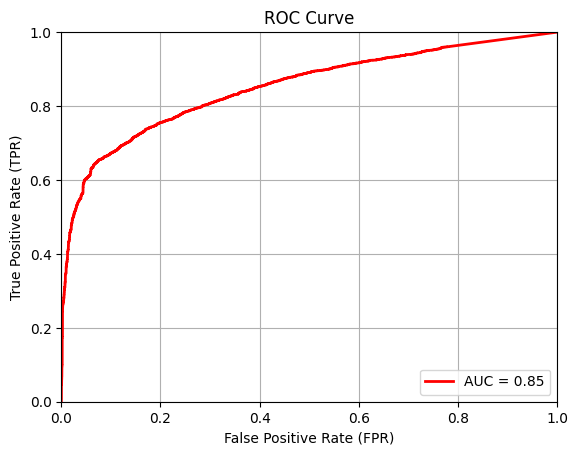

In [35]:
plot_roc_curve([1 if t>threshold_analogs else 0 for t in tanimotos_spec2vec], 
                        [s if s>0 else 0 for s in scores_spec2vec ])

## Run m2deepscore comparison

In [36]:
model_ms2d = load_model(model_ms2d_file)
similarity_ms2d = MS2DeepScore(model_ms2d)

In [41]:
random_molecule_pairs_indexes = np.random.choice(range(0,len(pairs)), size=2000)

In [42]:
random_pairs = [pairs[index] for index in random_molecule_pairs_indexes]

In [43]:
tanimoto_ms2, scores_ms2 = compute_score(spectrums, random_pairs, similarity_ms2d)

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3204.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6403.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19328.59it/s]

1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

1/1 [==============================] - 0s 10ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4922.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4549.14it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4999.17it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4350.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1860.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 194.48it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2549.73it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4911.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4766.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4696.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4424.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3423.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3816.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1307.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4271.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6909.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5309.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4826.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5159.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7653.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1169.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5841.65it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7231.56it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 484.27it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2414.68it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 6ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4350.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4629.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3379.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1066.17it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3246.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1602.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5017.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1831.57it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]


1/1 [==============================] - 0s 6ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4505.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 243.30it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2462.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4922.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6364.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7281.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]


1/1 [==============================] - 0s 6ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5005.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23431.87it/s]


1/1 [==============================] - 0s 6ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1733.18it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2434.30it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 839.70it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4443.12it/s]


1/1 [==============================] - 0s 6ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2353.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 6ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4624.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1530.77it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5370.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3415.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 472.33it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2974.68it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1486.29it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3728.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6743.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8490.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4848.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4064.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 612.75it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3533.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1991.60it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5295.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1155.77it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1234.71it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3744.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13662.23it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6177.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4588.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6786.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3986.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1615.68it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2493.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4346.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1275.64it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4310.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6909.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6452.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 226.29it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2880.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]


1/1 [==============================] - 0s 6ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4424.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4165.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3919.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4236.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6177.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4466.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6297.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6543.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2331.46it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2551.28it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4144.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 992.97it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4733.98it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18641.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4670.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 11ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1904.77it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4132.32it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4691.62it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4481.09it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4271.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4148.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1634.57it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4733.98it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4064.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3905.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18724.57it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3449.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2113.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2775.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2299.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4922.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2183.40it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4202.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4882.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4609.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2197.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4253.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 569.18it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3184.74it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4718.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13662.23it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5282.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5841.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1203.19it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6955.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4634.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5127.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19328.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7332.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4505.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18315.74it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


1/1 [==============================] - 0s 6ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 6ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2983.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1908.24it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6831.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2481.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6278.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 6ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6452.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3964.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


1/1 [==============================] - 0s 6ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3816.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2169.84it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6034.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6786.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5957.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5584.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6743.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1216.80it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5924.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2325.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4782.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 587.19it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2816.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 6ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2313.46it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12945.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1129.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3010.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5121.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5737.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2968.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9404.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 185.08it/s]

Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 855.98it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 6ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4675.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3144.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3894.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8665.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6141.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3165.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6657.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1324.80it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4236.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2890.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5645.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7256.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3905.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4328.49it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3905.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 908.25it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5203.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5053.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 504.49it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2519.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 693.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4809.98it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1264.11it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3833.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 171.94it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1133.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6141.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6842.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1019.27it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4766.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3533.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5614.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1039.22it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4429.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5159.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6452.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 774.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4922.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5005.14it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3876.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5983.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5023.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5289.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 448.64it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2236.96it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5029.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7598.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3498.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6335.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2168.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4691.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4832.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4169.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6177.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5957.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6594.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5184.55it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1808.67it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4524.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7281.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5356.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2313.46it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3692.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3480.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12087.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4999.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16194.22it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3721.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3498.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4718.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1528.54it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5084.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4013.69it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1741.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3460.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4481.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1015.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5691.05it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7256.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7503.23it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1176.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4696.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6700.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5262.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16194.22it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9118.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 741.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4275.54it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2319.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2283.24it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6034.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4002.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1739.65it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4424.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1154.50it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5785.25it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4788.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7281.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6502.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6177.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3609.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1488.40it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 632.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4029.11it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6955.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5184.55it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7825.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6177.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4588.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7825.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7476.48it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5269.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4387.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6786.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3692.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3236.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5071.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4629.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6364.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 138.87it/s]

Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 866.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3890.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7423.55it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7825.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1577.99it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2465.79it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1049.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4928.68it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 804.59it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9039.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 981.58it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5023.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4341.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 216.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4293.04it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14979.66it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 822.41it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3758.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10485.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8289.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7503.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3279.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1362.23it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 804.59it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4650.00it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4481.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3685.68it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4410.41it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4181.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2283.24it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4236.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4100.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3134.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1146.92it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5121.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1416.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6069.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3545.48it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4928.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3938.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7061.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 11ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3423.92it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5262.61it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7281.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7710.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2003.97it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4032.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1395.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2898.62it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3097.71it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4169.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6403.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2277.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 754.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5518.82it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13842.59it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 740.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5184.55it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4198.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 198.29it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1814.93it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 229.62it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1076.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7767.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5577.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 124.13it/s]

Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 872.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6403.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5825.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4032.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5071.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5983.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1095.40it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5184.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1043.62it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5071.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6403.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2525.17it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3650.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5825.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1428.58it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2985.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2008.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2132.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4169.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10951.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1398.57it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1886.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5412.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5384.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5489.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1641.61it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4505.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5165.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14979.66it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5974.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4310.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 258.33it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1204.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1602.71it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7332.70it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2475.98it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1481.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5282.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5924.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1394.85it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5841.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2427.26it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5548.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4544.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6141.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5077.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1879.17it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1501.72it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5983.32it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7256.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3594.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5370.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4832.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4928.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7108.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5295.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15477.14it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1880.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3125.41it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18315.74it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4485.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4563.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 558.05it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3675.99it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1321.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8176.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4826.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2993.79it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5584.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2481.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2786.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4650.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1337.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5722.11it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2420.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1666.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6452.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5584.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7653.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4481.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5084.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12087.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9238.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2380.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 541.41it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2661.36it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1961.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6423.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7710.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6909.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4882.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 608.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3597.17it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6364.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7653.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1259.55it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3144.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2537.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4860.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1440.85it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5384.22it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4788.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4609.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6765.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6955.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 896.22it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5071.71it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4350.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3509.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4443.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3771.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3483.64it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5440.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6069.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3545.48it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 154.32it/s]

Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 902.58it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7973.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1718.27it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4739.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7653.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3685.68it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4777.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16194.22it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3228.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4017.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2218.03it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6034.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1818.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7913.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4443.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5309.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3785.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5584.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5468.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6355.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3134.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7108.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8176.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4568.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5295.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5753.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3666.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4544.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4500.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6786.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4583.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5005.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 456.60it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2045.00it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4169.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4650.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1430.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6297.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6297.75it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1995.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5614.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2257.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6186.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3116.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 154.54it/s]

Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 961.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4096.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2462.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3731.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7281.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2183.40it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1111.37it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4064.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4655.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5127.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2062.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7503.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 859.84it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9642.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5584.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18641.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3634.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6364.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3890.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6052.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6177.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1205.95it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5468.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2267.19it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4424.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4328.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1959.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6502.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5504.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6452.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2933.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7256.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3492.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4198.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5309.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1830.77it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4588.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5256.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4549.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11155.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5412.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5706.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1273.32it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6721.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2198.27it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8289.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6765.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4696.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6765.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 360.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1550.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10381.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5785.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6909.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1260.69it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 313.48it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1436.41it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4181.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4739.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2385.84it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5077.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3320.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3331.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 155.77it/s]

Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 969.11it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5489.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1426.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6482.70it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5489.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3622.02it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5722.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23563.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3236.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2398.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3387.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5983.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3826.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1938.22it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1280.70it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4629.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6765.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3830.41it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2187.95it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4148.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 196.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2369.66it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1692.62it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 178.35it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1136.36it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3890.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5785.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1348.22it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1009.22it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1064.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6594.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12087.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1310.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7256.58it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7557.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 473.02it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3236.35it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13842.59it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 157.70it/s]

Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 941.48it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3287.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4346.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4670.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1426.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3426.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3986.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3998.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4310.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5706.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3521.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3236.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 671.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3398.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3334.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2570.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2321.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3819.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1858.35it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3194.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7503.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2173.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2267.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7913.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1829.18it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4462.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5426.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 865.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5084.00it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3847.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 992.97it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5706.54it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4832.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 190.77it/s]

Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 808.46it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2067.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4310.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4871.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4369.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 621.84it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2654.62it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 878.02it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5289.16it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 633.29it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4253.86it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3692.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1597.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4275.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4588.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1825.20it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8289.14it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3923.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 637.34it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2803.68it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 865.70it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3894.43it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4588.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5262.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3452.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1653.25it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4258.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2057.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2532.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4670.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4148.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5957.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4832.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4181.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10485.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6502.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4691.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3106.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6955.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5121.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 9ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6594.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6765.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2278.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3744.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3390.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4755.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14979.66it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2571.61it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6842.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2327.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1072.71it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4593.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 516.03it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4181.76it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8665.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1946.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6223.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4568.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3214.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5053.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6177.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7710.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8289.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5562.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6087.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2639.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1009.22it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7913.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3472.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1131.46it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5841.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2326.29it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2325.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7503.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10356.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6087.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4466.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6955.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9642.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5269.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16194.22it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7503.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3771.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7503.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5053.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 941.48it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5645.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4544.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6297.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 336.03it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1686.49it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 772.72it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4675.92it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8289.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13443.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2146.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5370.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2232.20it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6955.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1666.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1212.58it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6721.64it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6364.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1623.18it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5315.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1934.64it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7710.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1776.49it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4624.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1246.82it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6978.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3426.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2380.42it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5785.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4691.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4306.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5203.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4275.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2385.84it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5077.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4524.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1804.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4132.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3597.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16194.22it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1923.11it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8594.89it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6316.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1225.33it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1900.45it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1723.92it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6765.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6657.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5071.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12710.01it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6543.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4505.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5229.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3483.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3423.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4782.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1855.07it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4132.32it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4712.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12446.01it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2517.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5584.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13662.23it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4826.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2325.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6069.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3844.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1398.57it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6403.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1582.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4293.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4032.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5706.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1600.27it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3862.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6186.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6909.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1807.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5262.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6069.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8594.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 9ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3483.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13662.23it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2531.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4253.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2693.84it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5096.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1207.34it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6462.72it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1644.83it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 864.27it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5262.61it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1377.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 185.05it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2000.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1464.49it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4788.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4064.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7710.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2299.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4928.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4832.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3701.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4462.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1473.24it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2525.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 575.35it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3334.10it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1808.67it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 973.61it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6657.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2514.57it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2983.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4132.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1265.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6241.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5127.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3415.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5577.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1038.71it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5053.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5184.55it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 194.59it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1503.33it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3175.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1821.23it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11459.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5108.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7825.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3771.86it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6241.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4660.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3548.48it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5607.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1789.38it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1557.48it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7738.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3949.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2058.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2439.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3246.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2557.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5184.55it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5289.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3672.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5785.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5841.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4624.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1854.25it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4882.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5548.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 612.40it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3404.47it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5983.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9642.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 572.68it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2517.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5096.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 565.35it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3204.20it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3204.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3675.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2240.55it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3908.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4485.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5440.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4760.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6316.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5548.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3134.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12945.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1672.37it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5722.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6909.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 706.11it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2968.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17050.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5706.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6543.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4215.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3563.55it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4293.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5924.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4670.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14979.66it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4505.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5398.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12710.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4096.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2525.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5974.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5023.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4739.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4905.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3890.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6335.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1207.69it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4568.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4529.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1466.03it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12945.38it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 171.35it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1140.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6502.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5282.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3731.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4198.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4148.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1362.23it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6955.73it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5412.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5592.41it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2700.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6842.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6786.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2173.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1610.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3269.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6087.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1605.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2557.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7653.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4481.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4350.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7108.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6034.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6452.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4236.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2531.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6150.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2709.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6052.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2551.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12087.33it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4788.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4544.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6842.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5957.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1608.25it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2263.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7767.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1969.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2330.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6069.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1675.71it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3802.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1667.05it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6069.90it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4524.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3435.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4739.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3266.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 10ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2458.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3865.72it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4013.69it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4236.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4744.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2019.40it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7182.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2000.14it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 472.12it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2272.10it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2445.66it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1009.22it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7738.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3758.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1459.90it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2325.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5584.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4609.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1050.41it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5584.96it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3731.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11155.06it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.71it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3276.80it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4219.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16194.22it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1422.76it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1297.34it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1848.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2639.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3609.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 398.74it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2325.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4202.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13662.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1347.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4443.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14217.98it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3106.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5077.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3637.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2519.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3771.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4860.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5071.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6502.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 556.20it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3404.47it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2824.45it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6502.80it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1275.64it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2303.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5753.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 179.24it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2505.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13842.59it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 387.86it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2198.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3545.48it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6452.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1321.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6502.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2906.66it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3675.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5077.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6177.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4609.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6052.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4324.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5315.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1317.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5722.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4382.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 954.12it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4848.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4832.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1032.06it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26546.23it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2974.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4993.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15768.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4165.15it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3934.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5071.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6636.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1108.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4766.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4650.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4670.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1438.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4766.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7710.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4981.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4614.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10459.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2995.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6364.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1763.79it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8019.70it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5890.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1042.84it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3236.35it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4766.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4524.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2123.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4809.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12865.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1394.85it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6657.63it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5262.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 843.25it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6316.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6452.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3344.74it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1628.86it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4132.32it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2763.05it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12945.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 234.46it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2439.97it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7476.48it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2451.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4999.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7256.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4655.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2057.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5468.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3297.41it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18315.74it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2187.95it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2272.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6543.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3344.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5737.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1630.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5518.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5584.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12710.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12945.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2495.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5127.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5957.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4809.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2803.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4185.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1894.45it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4341.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1473.24it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4462.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 165.49it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1096.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2709.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23563.51it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1757.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6297.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6502.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4485.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5289.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6909.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5127.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5203.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5023.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3761.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3594.09it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4681.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 209.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1442.83it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5047.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2623.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10485.76it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3437.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 141.08it/s]

Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 984.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1189.20it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4064.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6462.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4718.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5874.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1149.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6364.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3819.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19328.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5370.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7476.48it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5518.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16194.22it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6297.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6955.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 743.41it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4549.14it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6452.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7157.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1195.98it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5077.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9642.08it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1101.45it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2652.94it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5203.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2087.76it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3816.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14027.77it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5071.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3048.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5737.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1897.02it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 867.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4271.19it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2514.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3701.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5722.11it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4136.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4766.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 505.83it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2428.66it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2029.17it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3542.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1829.18it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6502.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4691.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6502.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6909.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10485.76it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2725.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 321.75it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1631.39it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 383.85it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2947.51it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2434.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1259.55it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4382.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4760.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1267.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4832.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3731.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1804.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5047.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7503.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1398.57it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6978.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6765.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5282.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1711.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2387.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5184.55it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4443.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1472.20it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5957.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 196.74it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2734.23it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3731.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2666.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 200.28it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4809.98it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7476.48it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6955.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3919.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4505.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4860.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4401.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6909.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4275.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1242.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4443.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13662.23it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5924.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3581.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1042.84it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5440.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1639.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4466.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 923.25it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4275.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5412.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4462.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5005.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 205.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2849.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1531.33it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4563.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2480.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3998.38it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5262.61it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1490.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4832.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4588.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5133.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3650.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6955.73it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1473.24it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3761.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2449.94it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1313.59it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4524.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1878.33it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6842.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1851.79it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1123.57it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5584.96it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2228.64it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8176.03it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7503.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4524.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5874.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3938.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4629.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3050.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1164.11it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5053.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23563.51it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5440.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2474.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5614.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1560.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5785.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 655.26it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3612.66it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4696.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3876.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1709.17it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5053.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6978.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 927.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5370.43it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1494.76it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5315.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4629.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1355.19it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3184.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1623.81it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6452.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4832.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3880.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1125.99it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4563.99it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11683.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2603.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1201.81it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2192.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4116.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1908.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5592.41it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4332.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3182.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 123.84it/s]

Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 952.39it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4364.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1841.22it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4524.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 604.98it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3059.30it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4324.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4760.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9238.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2416.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6657.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6462.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3744.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5722.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5023.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3116.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5315.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16194.22it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2794.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11155.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1648.06it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7256.58it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4529.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1027.76it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4969.55it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13842.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3938.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4788.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13617.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2695.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4614.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14979.66it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2725.34it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4650.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 403.84it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2730.67it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3204.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2702.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1461.94it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 9ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2187.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 179.47it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1677.72it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5489.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3986.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4655.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2183.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1060.77it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7710.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3802.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4782.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1730.32it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1381.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3509.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1917.83it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5940.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4809.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 881.71it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5295.84it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5127.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3472.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.22it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3097.71it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4100.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13662.23it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6909.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6955.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4609.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 565.35it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2794.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5614.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1042.84it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4922.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1124.48it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5269.23it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5295.84it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3581.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 132.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1279.14it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5370.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3731.59it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5957.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 699.75it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3758.34it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 752.48it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3079.52it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 224.32it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1278.75it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5262.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2218.03it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4219.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4443.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3858.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6482.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 239.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3204.20it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2538.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3715.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3504.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7913.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4429.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 176.39it/s]

Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 989.22it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11459.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3106.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1685.81it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2007.80it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4832.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2198.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7767.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4202.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22429.43it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4505.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13842.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3165.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4629.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 623.41it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2799.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2763.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5753.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3964.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5262.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4219.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1520.23it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2158.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4443.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4524.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 138.29it/s]

Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 963.32it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5203.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4429.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11848.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4144.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4112.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4777.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12945.38it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8594.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5614.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10591.68it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7281.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1379.25it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6141.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1927.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8289.14it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 619.18it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3423.92it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4755.45it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19065.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1553.45it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3187.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2132.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9039.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4739.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4424.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6502.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1709.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8176.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4629.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4021.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1440.85it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6543.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4128.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4922.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5370.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4401.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5518.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5924.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3844.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5592.41it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5489.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1285.41it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3701.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6297.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3731.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2624.72it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3387.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5957.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4860.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4650.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5256.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7738.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6364.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2624.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7423.55it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1801.68it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4629.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3754.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2227.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1170.94it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5974.79it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2716.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 692.02it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4670.72it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5890.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2576.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5127.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6955.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5229.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1733.90it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7256.58it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6657.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4258.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5489.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3206.65it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2314.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5077.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 7ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6364.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1653.25it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]

1/1 [==============================] - 0s 7ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 8ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4032.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 8ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:42<00:00, 19.49it/s]


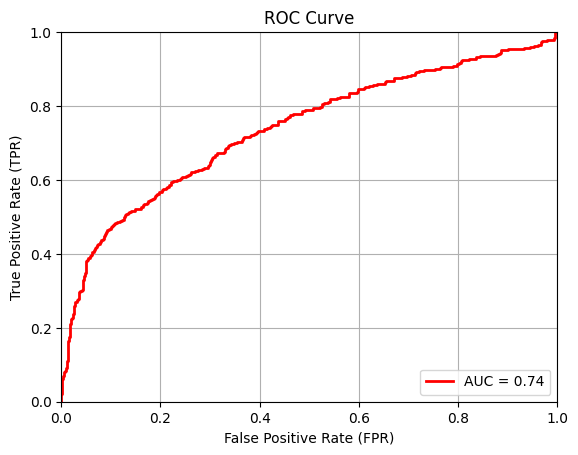

In [44]:
plot_roc_curve([1 if t>threshold_analogs else 0 for t in tanimoto_ms2], 
                        [s if s>0 else 0 for s in scores_ms2 ])